In [1]:
#Connect to Opticstudio
import clr, os, winreg
from itertools import islice

#READ ME
#For the following to function, you MUST have your optics file open in Optic Studio, and
#you MUST go to "Programming" and then click on "Interactive Extension", then run the
#python program.

# determine the Zemax working directory
aKey = winreg.OpenKey(winreg.ConnectRegistry(None, winreg.HKEY_CURRENT_USER), r"Software\Zemax", 0, winreg.KEY_READ)
zemaxData = winreg.QueryValueEx(aKey, 'ZemaxRoot')
NetHelper = os.path.join(os.sep, zemaxData[0], r'ZOS-API\Libraries\ZOSAPI_NetHelper.dll')
winreg.CloseKey(aKey)

# add the NetHelper DLL for locating the OpticStudio install folder
clr.AddReference(NetHelper)
import ZOSAPI_NetHelper

pathToInstall = ''
# uncomment the following line to use a specific instance of the ZOS-API assemblies
#pathToInstall = r'C:\C:\Program Files\Zemax OpticStudio'

# connect to OpticStudio
success = ZOSAPI_NetHelper.ZOSAPI_Initializer.Initialize(pathToInstall)

zemaxDir = ''
if success:
    zemaxDir = ZOSAPI_NetHelper.ZOSAPI_Initializer.GetZemaxDirectory()
    print('Found OpticStudio at:   %s' + zemaxDir)
else:
    raise Exception('Cannot find OpticStudio')

# load the ZOS-API assemblies
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI.dll'))
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI_Interfaces.dll'))
import ZOSAPI

TheConnection = ZOSAPI.ZOSAPI_Connection()
if TheConnection is None:
    raise Exception("Unable to intialize NET connection to ZOSAPI")

TheApplication = TheConnection.ConnectAsExtension(0)
if TheApplication is None:
    raise Exception("Unable to acquire ZOSAPI application")

if TheApplication.IsValidLicenseForAPI == False:
    raise Exception("License is not valid for ZOSAPI use.  Make sure you have enabled 'Programming > Interactive Extension' from the OpticStudio GUI.")

TheSystem = TheApplication.PrimarySystem
if TheSystem is None:
    raise Exception("Unable to acquire Primary system")

print('Connected to OpticStudio')
####################################################################################################

#Program Setup
import numpy as np
import scipy
import scipy.io as scipyio
import sys, time
import matplotlib.pyplot as plt
from astropy.io import fits
import csv
import math as m
from sklearn import datasets, linear_model

def transpose(data):
    """Transposes a 2D list (Python3.x or greater).  
    
    Useful for converting mutli-dimensional line series (i.e. FFT PSF)
    
    Parameters
    ----------
    data      : Python native list (if using System.Data[,] object reshape first)    
    
    Returns
    -------
    res       : transposed 2D list
    """
    if type(data) is not list:
        data = list(data)
    return list(map(list, zip(*data)))
    
def reshape(data, x, y, transpose = False):
    """Converts a System.Double[,] to a 2D list for plotting or post processing
    
    Parameters
    ----------
    data      : System.Double[,] data directly from ZOS-API 
    x         : x width of new 2D list [use var.GetLength(0) for dimension]
    y         : y width of new 2D list [use var.GetLength(1) for dimension]
    transpose : transposes data; needed for some multi-dimensional line series data
    
    Returns
    -------
    res       : 2D list; can be directly used with Matplotlib or converted to
                a numpy array using numpy.asarray(res)
    """
    if type(data) is not list:
        data = list(data)
    var_lst = [y] * x;
    it = iter(data)
    res = [list(islice(it, i)) for i in var_lst]
    if transpose:
        return self.transpose(res);
    return res
  
def Rx(deg):
    theta = deg * m.pi/180
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(deg):
    theta = deg * m.pi/180
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(deg):
    theta = deg * m.pi/180
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

##STAR Setup
analysis = TheSystem.Analyses
tools = TheSystem.Tools
surf_inds = [3,13,18,24,29,33,37,42,46,50]
surf_inds_old = [3,13,18,24,29,33,37,42,46,49]
surf_names = ['M1','M2','M3','LODM','Dicro','OAP1','OAP2','BMC','OAP3','VVC']
n_surf = len(surf_inds)

Found OpticStudio at:   %sc:\program files\ansys zemax opticstudio 2024 r1.03
Connected to OpticStudio


In [2]:
##Setup
sub_dir = 'pm_manual2_staticm1\\'
print('Directory: ' + sub_dir)
data_dir = 'c:\\Users\\locsst\\Desktop\\PICTURE_STOP_Rev2\\ansys\\STAR\\' + sub_dir
mf_dir = 'c:\\Users\\locsst\\Documents\\Zemax\\MeritFunction\\'

plotdir = '\\\\wsl.localhost\\Ubuntu\\home\\thadd\\idl\\end2end\\plots\\zemax\\' + sub_dir
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

dir_list = os.listdir(data_dir)

#Sort list by timestep
dir_list.sort(key=lambda x: int(x.split('_')[0]))

#Trim dense data
if len(dir_list) > 80:
    dir_list = dir_list[0:len(dir_list)-1:2]

nsteps = len(dir_list)
print('Number of steps: ' + str(nsteps))

TheLDE = TheSystem.LDE
move_m2 = TheLDE.GetSurfaceAt(10)
lodm_phase = TheLDE.GetSurfaceAt(surf_inds[3]-1)
surf_vvc = TheLDE.GetSurfaceAt(surf_inds[n_surf-1])
move_vvc = TheLDE.GetSurfaceAt(surf_inds[n_surf-1]-1)

chief_arr = np.zeros((n_surf,3,nsteps))
bwalk = np.zeros((n_surf,3,nsteps))
rdisp = np.zeros((n_surf,3,nsteps))
rot_surf = np.zeros((n_surf,3,nsteps))

disp_arr = np.zeros((n_surf,3,nsteps))
nominal_chief_arr = np.zeros((n_surf,3))

m2pos = np.zeros((6,nsteps))
nz = 11
zern_amp = np.zeros((nz,nsteps))

wf = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
wfsettings = wf.GetSettings()
wfsettings.set_RemoveTilt(True)
wfsettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_256x256
wfsettings.ShowAs = ZOSAPI.Analysis.Settings.Wavefront.FoucaultShowAs.FalseColor

wf.ApplyAndWaitForCompletion()
wfresults = wf.GetResults()
wfgrid = wfresults.GetDataGrid(0).Values
wfsize = [wfgrid.GetLength(0),wfgrid.GetLength(1)]

wfcube = np.zeros((wfsize[0],wfsize[1],nsteps))

Directory: pm_manual2_staticm1\
Number of steps: 79


In [3]:
##Functions
def truncate(vals, dec=0):
    return np.trunc(vals * 10**dec)/(10**dec)

def apply_m2corr(TheSystem, move_m2, vvc_x0, vvc_y0, hammer=0):
    tools.RemoveAllVariables()

    move_m2.ThicknessCell.MakeSolveVariable()
    move_m2.GetCellAt(12).MakeSolveVariable()
    move_m2.GetCellAt(13).MakeSolveVariable()
    move_m2.GetCellAt(14).MakeSolveVariable()
    move_m2.GetCellAt(15).MakeSolveVariable()
    #move_m2.GetCellAt(16).MakeSolveVariable()

    #Load OPD Merit Function
    TheSystem.MFE.LoadMeritFunction(mf_dir + 'tiptilt_zernike.MF')
    TheSystem.MFE.GetOperandAt(1).set_Target(vvc_x0)
    TheSystem.MFE.GetOperandAt(2).set_Target(vvc_y0)

    a = TheSystem.MFE.CalculateMeritFunction()
    xdev = vvc_x0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0)
    ydev = vvc_y0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0)
    dev = 25400 * np.sqrt(xdev**2 + ydev**2)

    print('MF Init: ',a,'| Dev:',dev)

    LocalOpt = TheSystem.Tools.OpenLocalOptimization()
    if (LocalOpt != None):
        LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Infinite
        LocalOpt.NumberOfCores = 32
        loopct = 1
        mftol = 5e-4

        while (a > mftol):
            print('LocalOpt',loopct, '| MF:',a,'| Dev:',dev, end='\r')

            LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
            LocalOpt.RunAndWaitWithTimeout(60)
            LocalOpt.Cancel()
            LocalOpt.WaitForCompletion()

            LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
            LocalOpt.RunAndWaitWithTimeout(60)
            LocalOpt.Cancel()
            LocalOpt.WaitForCompletion()

            #Calc convergence criteria
            a = LocalOpt.CurrentMeritFunction
            xdev = vvc_x0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0)
            ydev = vvc_y0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0)
            dev = 25400 * np.sqrt(xdev**2 + ydev**2)

            loopct +=1
            if loopct > 3:
                break

        print('LocalOpt',loopct-1, '| MF:',a,'| Dev:',dev) if (loopct > 1) else print('',end='\r')
        LocalOpt.Close()
    else:
        print('LocalOpt = None')

    if hammer == 1:
        HammerOpt = TheSystem.Tools.OpenHammerOptimization()
        if (HammerOpt != None):
            HammerOpt.Algorithm =  ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
            HammerOpt.NumberOfCores = 32

            loopct = 1
            mftol = 1e-4

            while (a > mftol):
                print('HammerOpt',loopct, '| MF:',a,'| Dev:',dev,end='\r')

                HammerOpt.RunAndWaitWithTimeout(120)
                HammerOpt.Cancel()
                HammerOpt.WaitForCompletion()

                #Calc convergence criteria
                a = HammerOpt.CurrentMeritFunction
                xdev = vvc_x0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0)
                ydev = vvc_y0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0)
                dev = 25400 * np.sqrt(xdev**2 + ydev**2)

                loopct +=1
                if loopct > 3:
                    break
            
            print('HammerOpt',loopct-1, '| MF:',a,'| Dev:',dev)   
            HammerOpt.Close()
        else:
            print('HammerOpt = None')

    #Print out correction converted to mm, deg
    m2corr = np.multiply(np.asarray([25.4,25.4,25.4,1,1,1]), \
        np.asarray([move_m2.GetCellAt(12).get_Value(),\
        move_m2.GetCellAt(13).get_Value(),\
        move_m2.ThicknessCell.get_Value(),\
        move_m2.GetCellAt(14).get_Value(),\
        move_m2.GetCellAt(15).get_Value(),\
        move_m2.GetCellAt(16).get_Value()],dtype='float64'))
    
    print('Final M2 Correction: ',truncate(m2corr,4))
    return m2corr

#Converts picture flight data to rotations about the true scope coords and mirror centroid
#Done in mm
#need to account for the initial position! w plot not at 0!
def convert_flight(scope_pos):
    home = np.asarray([-1.213673,3.527778,-0.157447,0.228300,0.437629,0.001699])

    #Get absolute position
    x = scope_pos[0] + home[0]
    y = scope_pos[1] + home[1]
    z = scope_pos[2] + home[2]
    u = scope_pos[3] + home[3]
    v = scope_pos[4] + home[4]
    w = scope_pos[5] + home[5]
    theta = -30

    # Undo the "bad" transformation to get back to hexapod coords
    ang = np.transpose(np.matmul(Rz(theta),np.asarray([u,v,w])))

    #Get rotation matrix in the hexapod coords that maps home to new pos.
    home_mat = np.matmul(np.matmul(Rx(home[3]),Ry(home[4])),Rz(home[5]))
    loc_mat = np.matmul(np.matmul(Rx(ang[0]),Ry(ang[1])),Rz(ang[2]))
    hex_mat = np.matmul(loc_mat,np.transpose(home_mat))

    #Convert matrices to telescope coords TRT^(-1)
    tel_mat = np.matmul(np.matmul(Rz(theta),hex_mat),Rz(-theta))
    home_mat_t = np.matmul(np.matmul(Rz(theta),home_mat),Rz(-theta))
    loc_mat_t = np.matmul(np.matmul(Rz(theta),loc_mat),Rz(-theta))

    #Get angles
    #Domain of asin is [-Pi/2,Pi/2] so cos is always positive
    #If you want j to be [0, Pi], then divide both parts of atan2 by cos(j)
    outvec = np.zeros((6))

    outvec[4] = 180/m.pi * np.arcsin(tel_mat[0,2])
    outvec[5] = 180/m.pi * np.arctan2(-tel_mat[0,1],tel_mat[0,0])
    outvec[3] = 180/m.pi * np.arctan2(-tel_mat[1,2],tel_mat[2,2])

    #get displacement in scope coords
    pos = (np.asarray([x,y,z]) - home[0:3]) #dont need to rotate the positions back and forth

    #apply rotation to vertex position
    #this should be in true telescope coords...
    vertex0 = np.asarray([-0.9,0.122,73.81])
    vertex1 = np.matmul(home_mat_t,vertex0)
    vertex2 = np.matmul(loc_mat_t,vertex0)
    disp_cen = np.transpose(vertex2 - vertex1)

    for i in range(3):
        outvec[i] = pos[i] + disp_cen[i]

    return outvec

#Converts m2 correction in zemax to the telescope frame (ORDER FLAG =: 1)
#This is done all in mm
def convert_zmx(zemax_pos):
    x = zemax_pos[0]
    y = zemax_pos[1]
    z = zemax_pos[2]
    u = zemax_pos[3]
    v = zemax_pos[4]
    w = zemax_pos[5]
    theta = -3.26 #Angle between zemax global and Telescope Coords (About X)

    #Get rotation matrix in the zemax frame 
    zemax_mat = np.matmul(np.matmul(Rz(w),Ry(v)),Rx(u))

    #Convert matrix to telescope coords TRT^(-1)
    tel_mat = np.matmul(np.matmul(Rx(theta),zemax_mat),Rx(-theta))

    #Get angles in correct rotation order
    #Domain of asin is [-Pi/2,Pi/2] so cos is always positive
    #If you want j to be [0, Pi], then divide both parts of atan2 by cos(j)

    outvec = np.zeros((6))
    outvec[4] = 180/m.pi * np.arcsin(tel_mat[0,2])
    outvec[5] = 180/m.pi * np.arctan2(-tel_mat[0,1],tel_mat[0,0])
    outvec[3] = 180/m.pi * np.arctan2(-tel_mat[1,2],tel_mat[2,2])

    #Project displacements onto the telescope frame 
    # (disps applied after rotation)
    hex_disp = np.transpose(np.matmul(np.matmul(Rx(theta),np.transpose(zemax_mat)),np.asarray([x,y,z])))

    for i in range(3):
        outvec[i] = hex_disp[i]
    return outvec

#Given some x and y rotations in the hexapod frame, what z rotation is needed to make it spannable by the hexapod basis with no z rotation?
def calc_twist(xang,yang):
    theta = xang * m.pi/180
    phi = yang * m.pi/180

    ycoord = (np.sqrt(3)*np.cos(phi) - np.sqrt(3)*np.cos(theta) - np.sin(phi)*np.sin(theta))/ \
    (3*np.cos(phi) + np.cos(theta) - np.sqrt(3)*np.sin(phi)*np.sin(theta))
    
    return np.arctan(ycoord,1) * (180/m.pi)

def apply_lodmcorr(TheSystem,lodm_phase,vvc_x0,vvc_y0):
    tools.RemoveAllVariables()
    ##New optimization routine for LODM, since localopt is so slow (TY Josh)
    nz = 11
    tol = 10 ** (-7)
    zernikes = np.zeros((nz))
    corr_amp = np.zeros((nz))

    for i in range(1):

        #Tip tilt correction
        lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).MakeSolveVariable()
        lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).MakeSolveVariable()

        TheSystem.MFE.LoadMeritFunction(mf_dir + 'tiptilt.mf')
        TheSystem.MFE.GetOperandAt(1).set_Target(vvc_x0)
        TheSystem.MFE.GetOperandAt(2).set_Target(vvc_y0)

        LocalOpt = TheSystem.Tools.OpenLocalOptimization()
        if (LocalOpt != None):
            LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
            LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Infinite
            LocalOpt.NumberOfCores = 32

            loopct = 0
            while LocalOpt.CurrentMeritFunction > tol:
                LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
                LocalOpt.RunAndWaitWithTimeout(25)
                LocalOpt.Cancel()
                LocalOpt.WaitForCompletion()
                loopct += 1
                if loopct == 3:
                    LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
                    LocalOpt.RunAndWaitWithTimeout(10)
                    LocalOpt.Cancel()
                    LocalOpt.WaitForCompletion()
                if loopct > 5:
                    break

        print('Final Merit Function for tip/tilt: ', LocalOpt.CurrentMeritFunction)            
        LocalOpt.Close()

        corr_amp[0] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).get_Value()
        corr_amp[1] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).get_Value()

        #Higher order terms
        TheSystem.MFE.LoadMeritFunction(mf_dir + 'zernike.mf')
        loopct = 0
        a = 1

        while a > tol:
            #Get current amplitudes
            corr_amp[2] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).get_Value()
            corr_amp[3] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).get_Value()
            corr_amp[4] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).get_Value()
            corr_amp[5] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).get_Value()
            corr_amp[6] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).get_Value()
            corr_amp[7] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).get_Value()
            corr_amp[8] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).get_Value()
            corr_amp[9] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).get_Value()
            corr_amp[10] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).get_Value()

            for i in range(2,nz):
                zernikes[i] = (0.98 ** loopct) * TheSystem.MFE.GetOperandAt(i+1).get_Value()

            #Set new values (signs were figured out manually)
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).set_DoubleValue(corr_amp[2]+zernikes[2])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).set_DoubleValue(corr_amp[3]+zernikes[3])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).set_DoubleValue(corr_amp[4]+zernikes[4])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).set_DoubleValue(corr_amp[5]+zernikes[5])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).set_DoubleValue(corr_amp[6]+zernikes[6])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).set_DoubleValue(corr_amp[7]+zernikes[7])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).set_DoubleValue(corr_amp[8]+zernikes[8])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).set_DoubleValue(corr_amp[9]+zernikes[9])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).set_DoubleValue(corr_amp[10]+zernikes[10])

            a = TheSystem.MFE.CalculateMeritFunction()
            loopct += 1

            if loopct > 15:
                break

        corr_amp[2] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).get_Value()
        corr_amp[3] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).get_Value()
        corr_amp[4] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).get_Value()
        corr_amp[5] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).get_Value()
        corr_amp[6] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).get_Value()
        corr_amp[7] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).get_Value()
        corr_amp[8] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).get_Value()
        corr_amp[9] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).get_Value()
        corr_amp[10] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).get_Value()

        print('Final Merit Function for Zernikes: ',a)

    return np.asarray(corr_amp)

def apply_lodmcorr2(TheSystem,lodm_phase,vvc_x0,vvc_y0):
    ##New optimization routine for LODM, since localopt is so slow (TY Josh)
    nz = 11
    tol = 10 ** (-7)
    zernikes = np.zeros((nz))
    corr_amp = np.zeros((nz))

    #Tip tilt + Zernike correction (make LODM zernikes variable)
    tools.RemoveAllVariables()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).MakeSolveVariable()
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).MakeSolveVariable()

    
    TheSystem.MFE.LoadMeritFunction(mf_dir + 'tiptilt_zernike.MF')
    TheSystem.MFE.GetOperandAt(1).set_Target(vvc_x0)
    TheSystem.MFE.GetOperandAt(2).set_Target(vvc_y0)

    LocalOpt = TheSystem.Tools.OpenLocalOptimization()
    if (LocalOpt != None):
        LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Infinite
        LocalOpt.NumberOfCores = 32
 
        a = LocalOpt.CurrentMeritFunction
        xdev = vvc_x0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0)
        ydev = vvc_y0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0)
        dev = 25400 * np.sqrt(xdev**2 + ydev**2)

        print('MF Init: ',a,'| Dev:',dev)

        loopct = 1
        while a > tol:
            print('LocalOpt',loopct, '| MF:',a,'| Dev:',dev, end='\r')
            LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
            LocalOpt.RunAndWaitWithTimeout(60)
            LocalOpt.Cancel()
            LocalOpt.WaitForCompletion()

            LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
            LocalOpt.RunAndWaitWithTimeout(60)
            LocalOpt.Cancel()
            LocalOpt.WaitForCompletion()

            a = LocalOpt.CurrentMeritFunction
            xdev = vvc_x0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0)
            ydev = vvc_y0 -TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0)
            dev = 25400 * np.sqrt(xdev**2 + ydev**2)
            
            loopct += 1

            if loopct > 5:
                print('LODM Optimization Timeout')
                break
        print('LocalOpt',loopct-1, '| MF:',a,'| Dev:',dev) if (loopct > 1) else print('',end='\r')
        print('Final Merit Function: ', LocalOpt.CurrentMeritFunction)            
        LocalOpt.Close()
  
    #Get current amplitudes
    corr_amp[0] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).get_Value()
    corr_amp[1] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).get_Value()
    corr_amp[2] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).get_Value()
    corr_amp[3] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).get_Value()
    corr_amp[4] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).get_Value()
    corr_amp[5] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).get_Value()
    corr_amp[6] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).get_Value()
    corr_amp[7] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).get_Value()
    corr_amp[8] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).get_Value()
    corr_amp[9] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).get_Value()
    corr_amp[10] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).get_Value()

  
    return np.asarray(corr_amp)

#Calc Beamwalk
def calc_beamwalk(TheSystem, chiefray_nom, i, n_surf):

    ##Get chiefray intercept position in global
    #Except for vvc (since it is moved by coord break, only need local)
    if i == n_surf-1:
        chiefray = np.asarray([TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAZ, surf_inds[i],0,0,0,0,0,0,0)])
    else:
        chiefray = np.asarray([TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, surf_inds[i],0,0,0,0,0,0,0)])

    ##Get ray motion
    tmp_disp = chiefray - chiefray_nom[i,:]

    ##Get normal and ray vector in local coords
    global_conv = np.zeros((3,3))
    for j in range(9):
        global_conv[m.floor(j / 3), j % 3] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.GLCR, surf_inds[i],j+1,0,0,0,0,0,0)

    n_vec = np.asarray([TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENA, surf_inds[i],0,0,0,0,0,0,0),\
    TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENB, surf_inds[i],0,0,0,0,0,0,0),\
    TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENC, surf_inds[i],0,0,0,0,0,0,0)])

    r_vec = np.asarray([TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAA, surf_inds[i],0,0,0,0,0,0,0),\
    TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAB, surf_inds[i],0,0,0,0,0,0,0),\
    TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAC, surf_inds[i],0,0,0,0,0,0,0)])

    n_vec = np.matmul(global_conv,n_vec)
    r_vec = np.matmul(global_conv,r_vec)
    
    #Correct sign errors from propagation direction flipping
    if (i % 2 == 0) or (i == n_surf-1):
        r_vec = -1 * r_vec
    else:
        n_vec = -1 * n_vec

    #Create/normalize surface x,y unit vectors in global coord basis
    #X such that it is perpendicular to global y
    xs = np.cross([0,1,0], n_vec)
    xs = xs/np.linalg.norm(xs)
    #and y is z cross x
    ys = np.cross(n_vec,xs)
    ys = ys/np.linalg.norm(ys)

    #Get pre-reflection ray vector in the surface coord system 
    # (skip reflection for transmissive elements, in this case the vvc)
    if i != n_surf-1:
        zrg = r_vec/np.linalg.norm(r_vec)
    else:
        zr = [np.dot(r_vec,xs), np.dot(r_vec,ys), -np.dot(r_vec,n_vec)]
        #Convert back to global
        zrg = zr[0] * xs + zr[1] * ys + zr[2] * n_vec
        zrg = zrg/np.linalg.norm(zrg)

    #Create/normalize surface x,y unit vectors
    #X such that it is perpendicular to global y
    xrg = np.cross([0,1,0], zrg)
    xrg = xrg/np.linalg.norm(xrg)
    #and y is z cross x
    yrg = np.cross(zrg,xrg)
    yrg = yrg/np.linalg.norm(yrg)

    #Get displacement values in global coords
    surf_tmp = TheLDE.GetSurfaceAt(surf_inds[i])
    surf_tmp.STARData.Deformations.RBMs.GetTransformValues()

    disp_surf = np.asarray([surf_tmp.STARData.Deformations.RBMs.Decenters.X,\
        surf_tmp.STARData.Deformations.RBMs.Decenters.Y,\
        surf_tmp.STARData.Deformations.RBMs.Decenters.Z]) 

    rotations = np.asarray([surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Alpha,\
        surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Beta,\
        surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Gamma])

    ##Subtract ray motion from optic motion
    #Ignore optic motion for vvc since it is moved from coordbreak
    if i != n_surf-1:
        bwalk_glob = disp_surf - tmp_disp
    else:
        bwalk_glob = -1 * tmp_disp

    #Convert beamwalk to ray coordinate system
    bwalk = np.asarray([np.dot(bwalk_glob,xrg),np.dot(bwalk_glob,yrg),np.dot(bwalk_glob,zrg)])
        
    #Convert optic motion to ray coordinate system    
    disps = np.asarray([np.dot(disp_surf,xrg),np.dot(disp_surf,yrg),np.dot(disp_surf,zrg)])

    return bwalk, disps, rotations, chiefray

In [4]:
##Clear Any Leftover STAR Data from previous runs, reset variables
for i in range(n_surf):
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.UnloadData()

move_m2.ThicknessCell.set_DoubleValue(0)
move_m2.GetCellAt(12).set_DoubleValue(0)
move_m2.GetCellAt(13).set_DoubleValue(0)
move_m2.GetCellAt(14).set_DoubleValue(0)
move_m2.GetCellAt(15).set_DoubleValue(0)
move_m2.GetCellAt(16).set_DoubleValue(0)

move_vvc.ThicknessCell.set_DoubleValue(0)
move_vvc.GetCellAt(12).set_DoubleValue(0)
move_vvc.GetCellAt(13).set_DoubleValue(0)
move_vvc.GetCellAt(14).set_DoubleValue(0)
move_vvc.GetCellAt(15).set_DoubleValue(0)
move_vvc.GetCellAt(16).set_DoubleValue(0)

lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).set_DoubleValue(0)

#Get data from nominal system
for i in range(n_surf):
    if i == n_surf-1:
        #With VVC disps, different method for beamwalk...
        nominal_chief_arr[i,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[i],0,0,0,0,0,0,0)
        nominal_chief_arr[i,1] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[i],0,0,0,0,0,0,0)
        nominal_chief_arr[i,2] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAZ, surf_inds[i],0,0,0,0,0,0,0)
    else:
        nominal_chief_arr[i,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, surf_inds[i],0,0,0,0,0,0,0)
        nominal_chief_arr[i,1] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, surf_inds[i],0,0,0,0,0,0,0)
        nominal_chief_arr[i,2] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, surf_inds[i],0,0,0,0,0,0,0)

#Get initial reference point for VVC
vvc_x0 = nominal_chief_arr[n_surf-1,0]
vvc_y0 = nominal_chief_arr[n_surf-1,1]
vvc_z0 = nominal_chief_arr[n_surf-1,1]

wf.ApplyAndWaitForCompletion()

In [5]:
##Run initial timestep
for i in range(n_surf):
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.UnloadData()

for i in range(n_surf):
    disp_file = data_dir + dir_list[0] + '\\Surface_' + str(surf_inds_old[i]).zfill(2) + '_Deformation.txt'
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.SetDataIsGlobal()
    #TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.CoordinateTransform.SetTransformValuesWithAngles(0,3.24,180,0,0,0)
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.CoordinateTransform.SetTransformValuesWithAngles(0,0,0,0,0,0)
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.Fits.Settings.SetAllValues(2,2,2,10,10**(-9),0.5)
    
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.ImportDeformations(disp_file)
    
#Add VVC displacements
surf_vvc.STARData.Deformations.RBMs.GetTransformValues()
disp_surf = np.asarray([surf_vvc.STARData.Deformations.RBMs.Decenters.X,\
    surf_vvc.STARData.Deformations.RBMs.Decenters.Y,\
    surf_vvc.STARData.Deformations.RBMs.Decenters.Z,\
    surf_vvc.STARData.Deformations.RBMs.Rotations.Angles.Alpha,\
    surf_vvc.STARData.Deformations.RBMs.Rotations.Angles.Beta,\
    surf_vvc.STARData.Deformations.RBMs.Rotations.Angles.Gamma])

move_vvc.ThicknessCell.set_DoubleValue(disp_surf[0])
move_vvc.GetCellAt(12).set_DoubleValue(disp_surf[1])
move_vvc.GetCellAt(13).set_DoubleValue(disp_surf[2])
move_vvc.GetCellAt(14).set_DoubleValue(disp_surf[3])
move_vvc.GetCellAt(15).set_DoubleValue(disp_surf[4])
move_vvc.GetCellAt(16).set_DoubleValue(disp_surf[5])

wf.ApplyAndWaitForCompletion()

In [6]:
##Apply M2 Correction
m2pos[:,0] = apply_m2corr(TheSystem, move_m2,vvc_x0,vvc_y0,1)
wf.ApplyAndWaitForCompletion()

MF Init:  0.18013011052937766 | Dev: 3169.7131426579895
LocalOpt 3 | MF: 0.0012158809283219455 | Dev: 1.6130030494175556
HammerOpt 3 | MF: 0.00046164804118310456 | Dev: 0.013345453446459
Final M2 Correction:  [ 0.1319 -0.5878 -2.3513 -0.025   0.0089  0.    ]


In [7]:
##Apply LODM correction to first timestep, calc beamwalk
tools.RemoveAllVariables()
if 1:
  zern_amp[:,0] = apply_lodmcorr(TheSystem,lodm_phase,vvc_x0,vvc_y0)
  print(zern_amp[:,0])

#Calculate Beamwalk
for i in range(n_surf):
  bwalk[i,:,0], rdisp[i,:,0], rot_surf[i,:,0], chief_arr[i,:,0] = calc_beamwalk(TheSystem,nominal_chief_arr, i, n_surf)

wf.ApplyAndWaitForCompletion()
wfresults = wf.GetResults()
wfgrid = wfresults.GetDataGrid(0).Values
wfarr = reshape(wfgrid,wfgrid.GetLength(0),wfgrid.GetLength(1))

wfcube[:,:,0] = wfarr
print(np.round(25400 * bwalk[n_surf-1,:,0],decimals=3))

Final Merit Function for tip/tilt:  9.422663515941081e-08
Final Merit Function for Zernikes:  9.631321691655499e-07
[-5.39953003e-13 -5.14338450e-13  4.90172320e-02 -1.14898482e-03
  7.28741896e-03 -4.02344787e-02 -3.93043739e-03 -6.97760448e-02
  1.71136635e-04  5.52710443e-02 -3.77148156e-03]
[0.646 3.203 0.332]


[-4.52821004e-02 -7.27400023e-01 -2.40959275e+00  1.56492350e-02
  2.31654625e-02 -1.32583429e-03]


In [8]:
for j in range(1,nsteps):
    print(f'Timestep: {str(j)} of {str(nsteps-1)}')

    for i in range(n_surf):
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.UnloadData()
    
    #Open displacement data
    for i in range(n_surf):
        disp_file = data_dir + dir_list[j] + '\\Surface_' + str(surf_inds_old[i]).zfill(2) + '_Deformation.txt'
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.SetDataIsGlobal()
        #TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.CoordinateTransform.SetTransformValuesWithAngles(0,3.24,180,0,0,0)
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.CoordinateTransform.SetTransformValuesWithAngles(0,0,0,0,0,0)
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.Fits.Settings.SetAllValues(2,2,2,10,10**(-9),0.5)
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.ImportDeformations(disp_file)

    #Move VVC
    surf_vvc.STARData.Deformations.RBMs.GetTransformValues()
    disp_surf = np.asarray([surf_vvc.STARData.Deformations.RBMs.Decenters.X,\
      surf_vvc.STARData.Deformations.RBMs.Decenters.Y,\
      surf_vvc.STARData.Deformations.RBMs.Decenters.Z,\
      surf_vvc.STARData.Deformations.RBMs.Rotations.Angles.Alpha,\
      surf_vvc.STARData.Deformations.RBMs.Rotations.Angles.Beta,\
      surf_vvc.STARData.Deformations.RBMs.Rotations.Angles.Gamma])

    move_vvc.ThicknessCell.set_DoubleValue(disp_surf[0])
    move_vvc.GetCellAt(12).set_DoubleValue(disp_surf[1])
    move_vvc.GetCellAt(13).set_DoubleValue(disp_surf[2])
    move_vvc.GetCellAt(14).set_DoubleValue(disp_surf[3])
    move_vvc.GetCellAt(15).set_DoubleValue(disp_surf[4])
    move_vvc.GetCellAt(16).set_DoubleValue(disp_surf[5])

    #Calc LODM correction
    if 0:
        zern_amp[:,j] = apply_lodmcorr(TheSystem,lodm_phase,vvc_x0,vvc_y0)

    #Calc secondary position
    if 0:
        m2pos[:,j] = apply_m2corr(TheSystem, move_m2,vvc_x0,vvc_y0,0)
    #Calculate Beamwalk (Do in local coords for VVC)
    for i in range(n_surf):
        bwalk[i,:,j], rdisp[i,:,j], rot_surf[i,:,j], chief_arr[i,:,j] = calc_beamwalk(TheSystem,nominal_chief_arr, i, n_surf)

    print(np.round(25400 * bwalk[n_surf-1,:,j],decimals=3))

    wf.ApplyAndWaitForCompletion()
    wfresults = wf.GetResults()
    wfgrid = wfresults.GetDataGrid(0).Values
    wfarr = reshape(wfgrid,wfgrid.GetLength(0),wfgrid.GetLength(1))
    wfcube[:,:,j] = wfarr

Timestep: 1 of 78
[ 14.47  -14.53    7.416]
Timestep: 2 of 78
[ 38.056 -65.571  19.499]
Timestep: 3 of 78
[ 23.751 -41.561  12.168]
Timestep: 4 of 78
[-3.694 -2.498 -1.895]
Timestep: 5 of 78
[-40.69  -33.862 -20.873]
Timestep: 6 of 78
[-99.006 -85.856 -50.781]
Timestep: 7 of 78
[-50.864 -85.207 -26.1  ]
Timestep: 8 of 78
[ 26.749 -79.323  13.698]
Timestep: 9 of 78
[ 44.738 -31.928  22.933]
Timestep: 10 of 78
[59.406 33.462 30.474]
Timestep: 11 of 78
[50.665 -0.209 25.982]
Timestep: 12 of 78
[ 32.383 -62.099  16.59 ]
Timestep: 13 of 78
[ 27.7   -37.272  14.194]
Timestep: 14 of 78
[24.217  7.118 12.42 ]
Timestep: 15 of 78
[28.711 -4.41  14.721]
Timestep: 16 of 78
[ 41.303 -29.545  21.172]
Timestep: 17 of 78
[ 28.227 -25.191  14.468]
Timestep: 18 of 78
[  2.484 -17.648   1.269]
Timestep: 19 of 78
[20.242 61.173 10.399]
Timestep: 20 of 78
[ 52.374 180.454  26.926]
Timestep: 21 of 78
[58.233 95.05  29.894]
Timestep: 22 of 78
[ 73.601 -48.595  37.732]
Timestep: 23 of 78
[19.277 -2.963  9.884

[ 0.29288348 -0.8633178  -1.44471265 -0.04623997 -0.02662698  0.00149509]
[0.86425596]


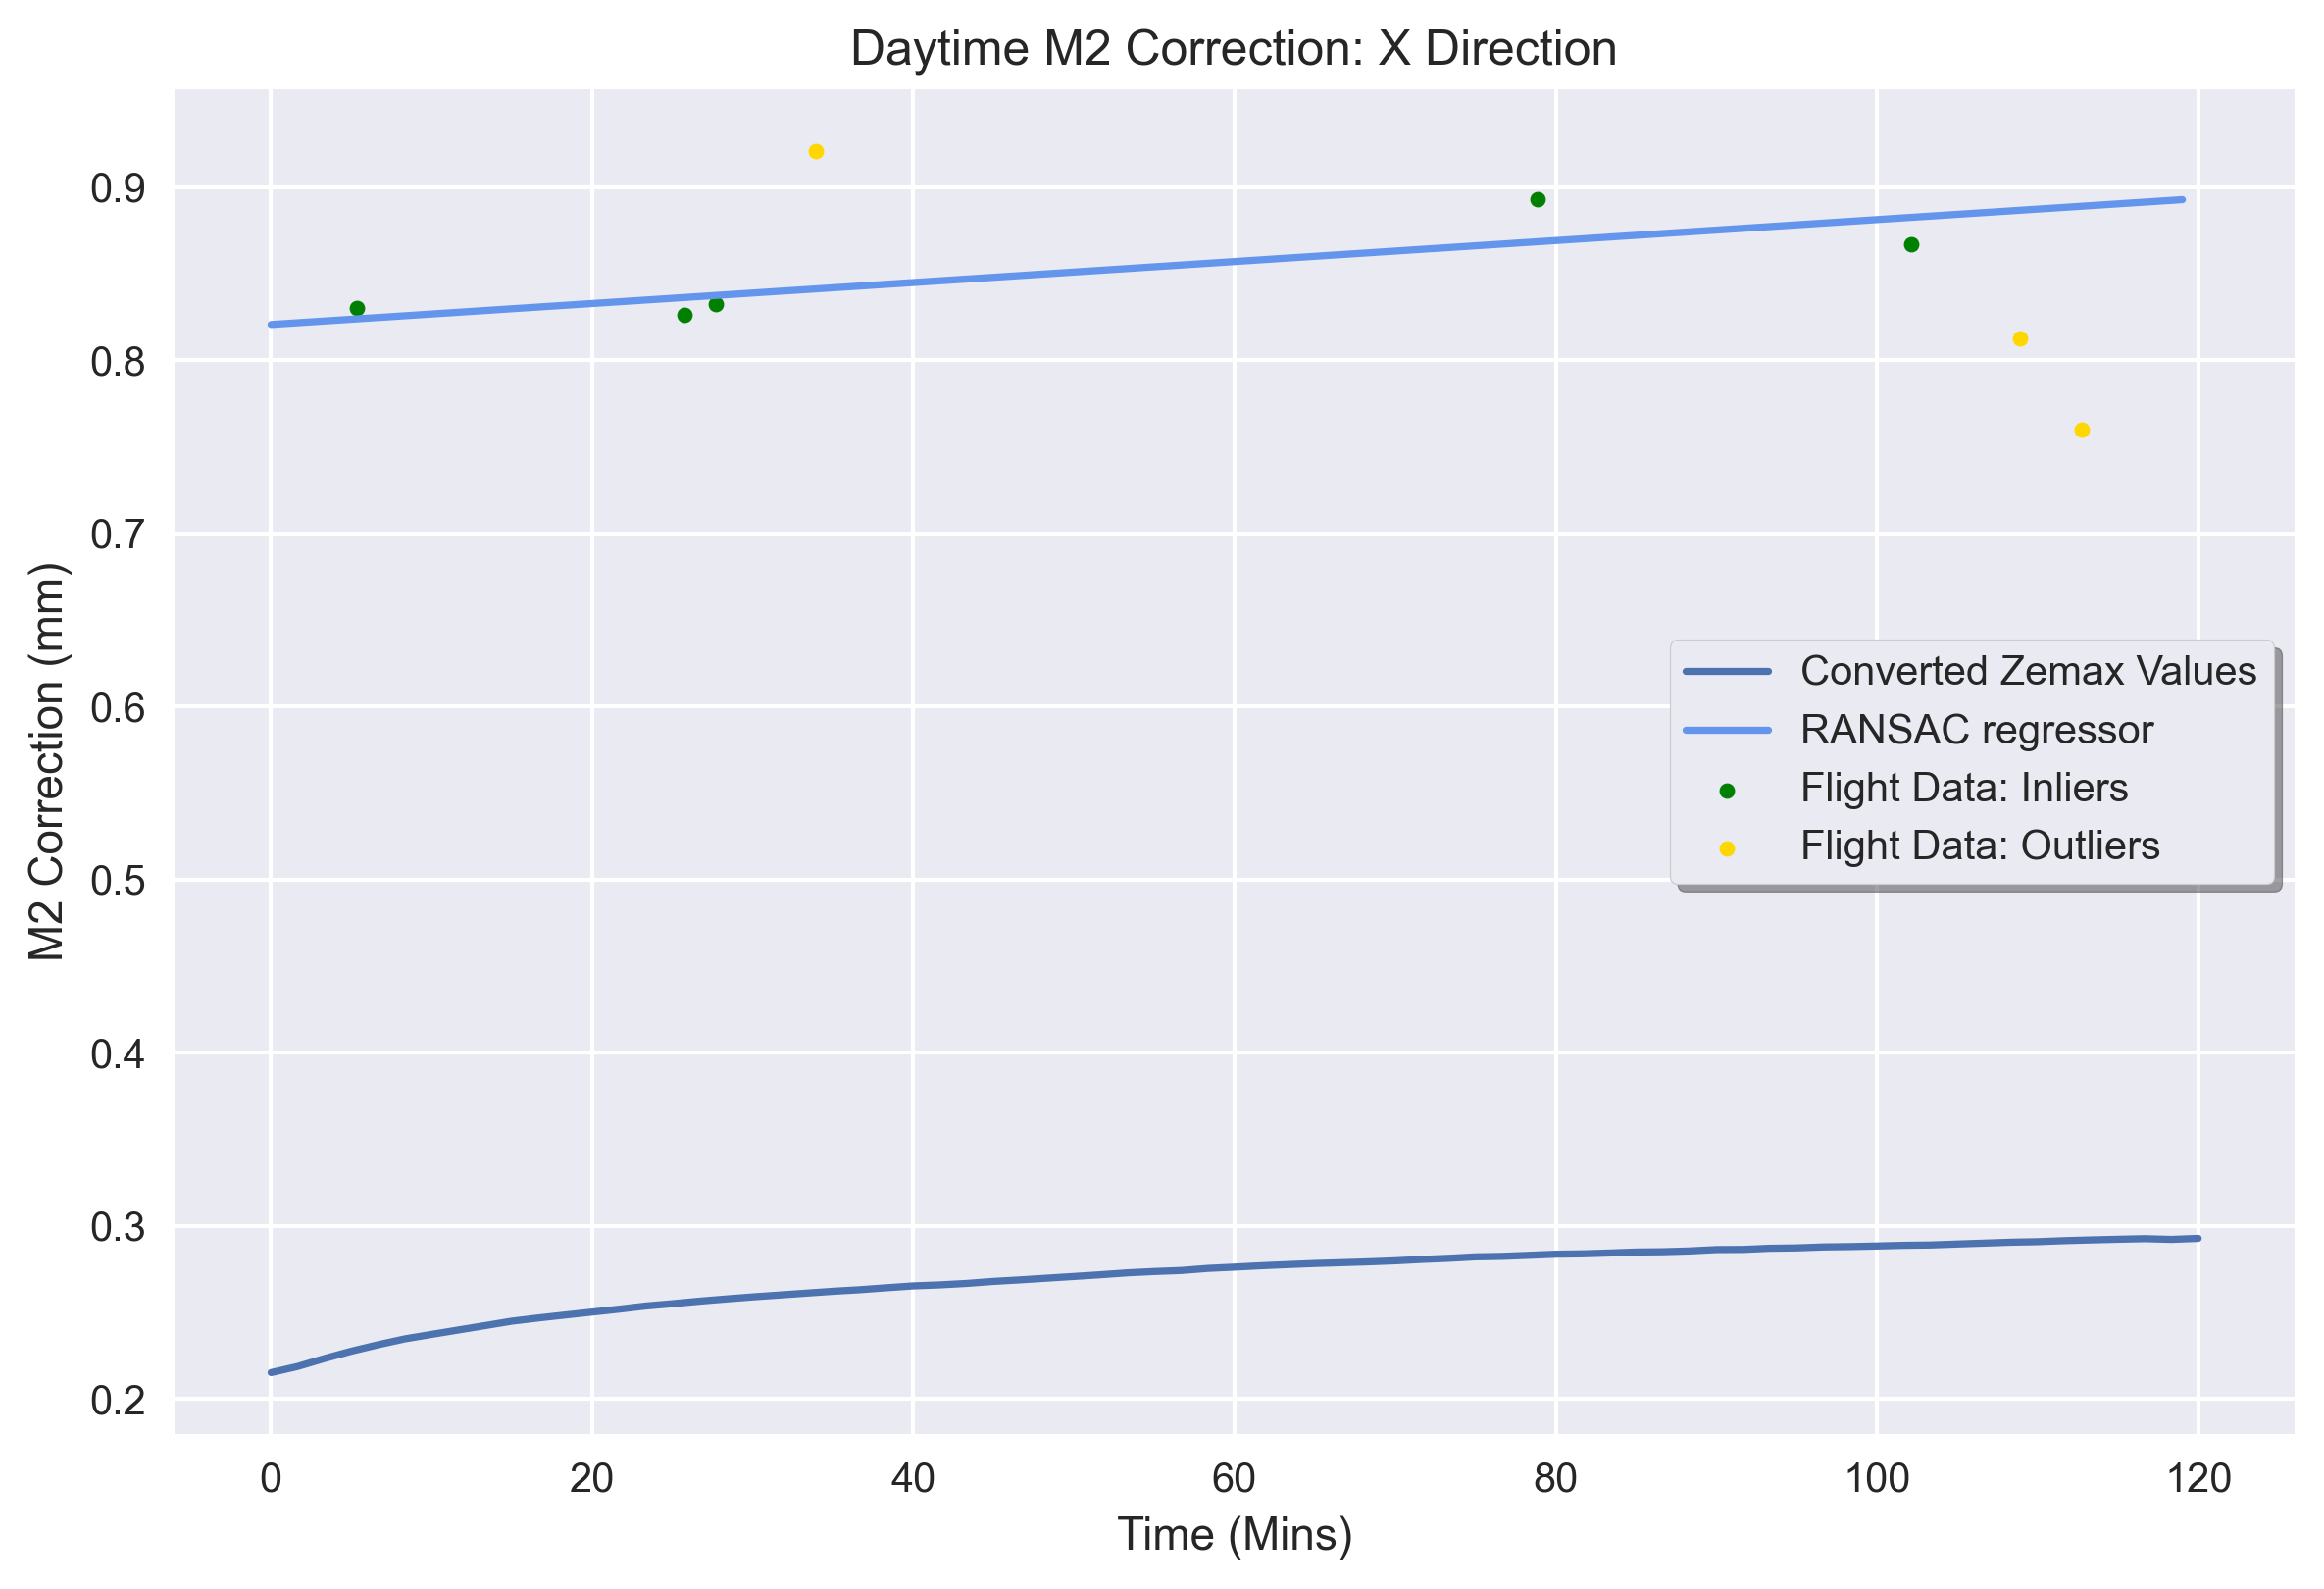

[-2.67379868]


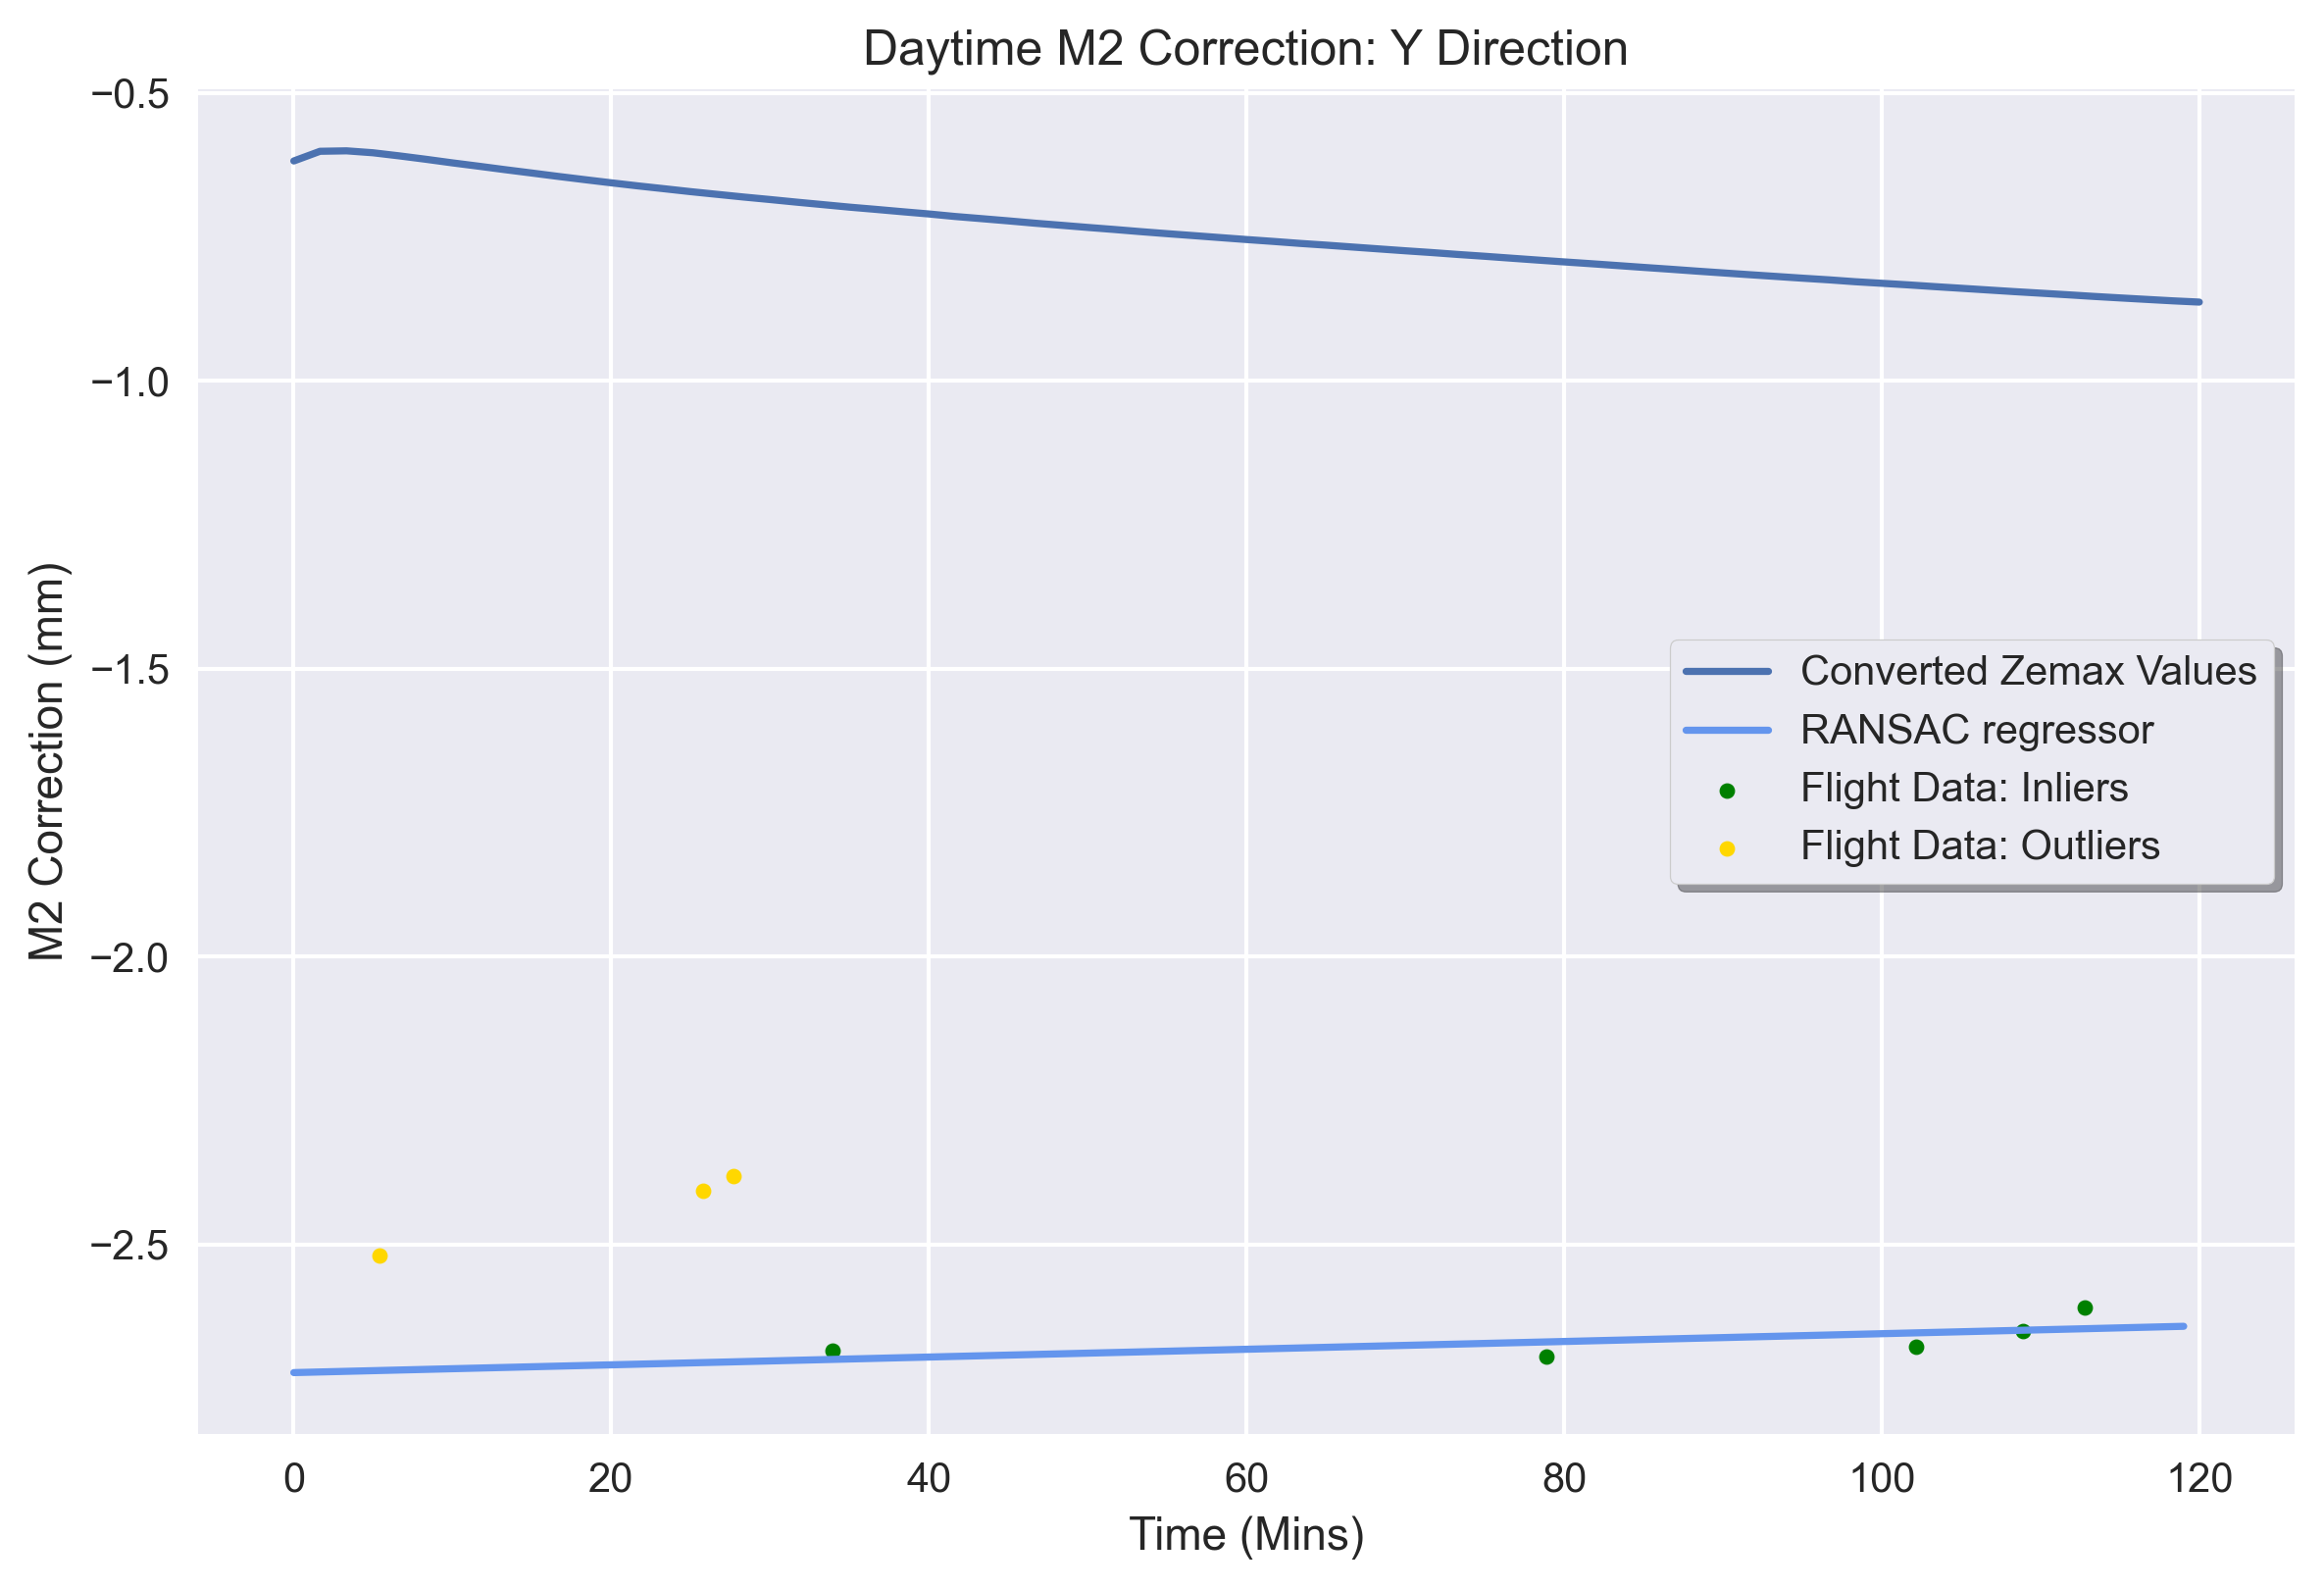

[-1.18071295]


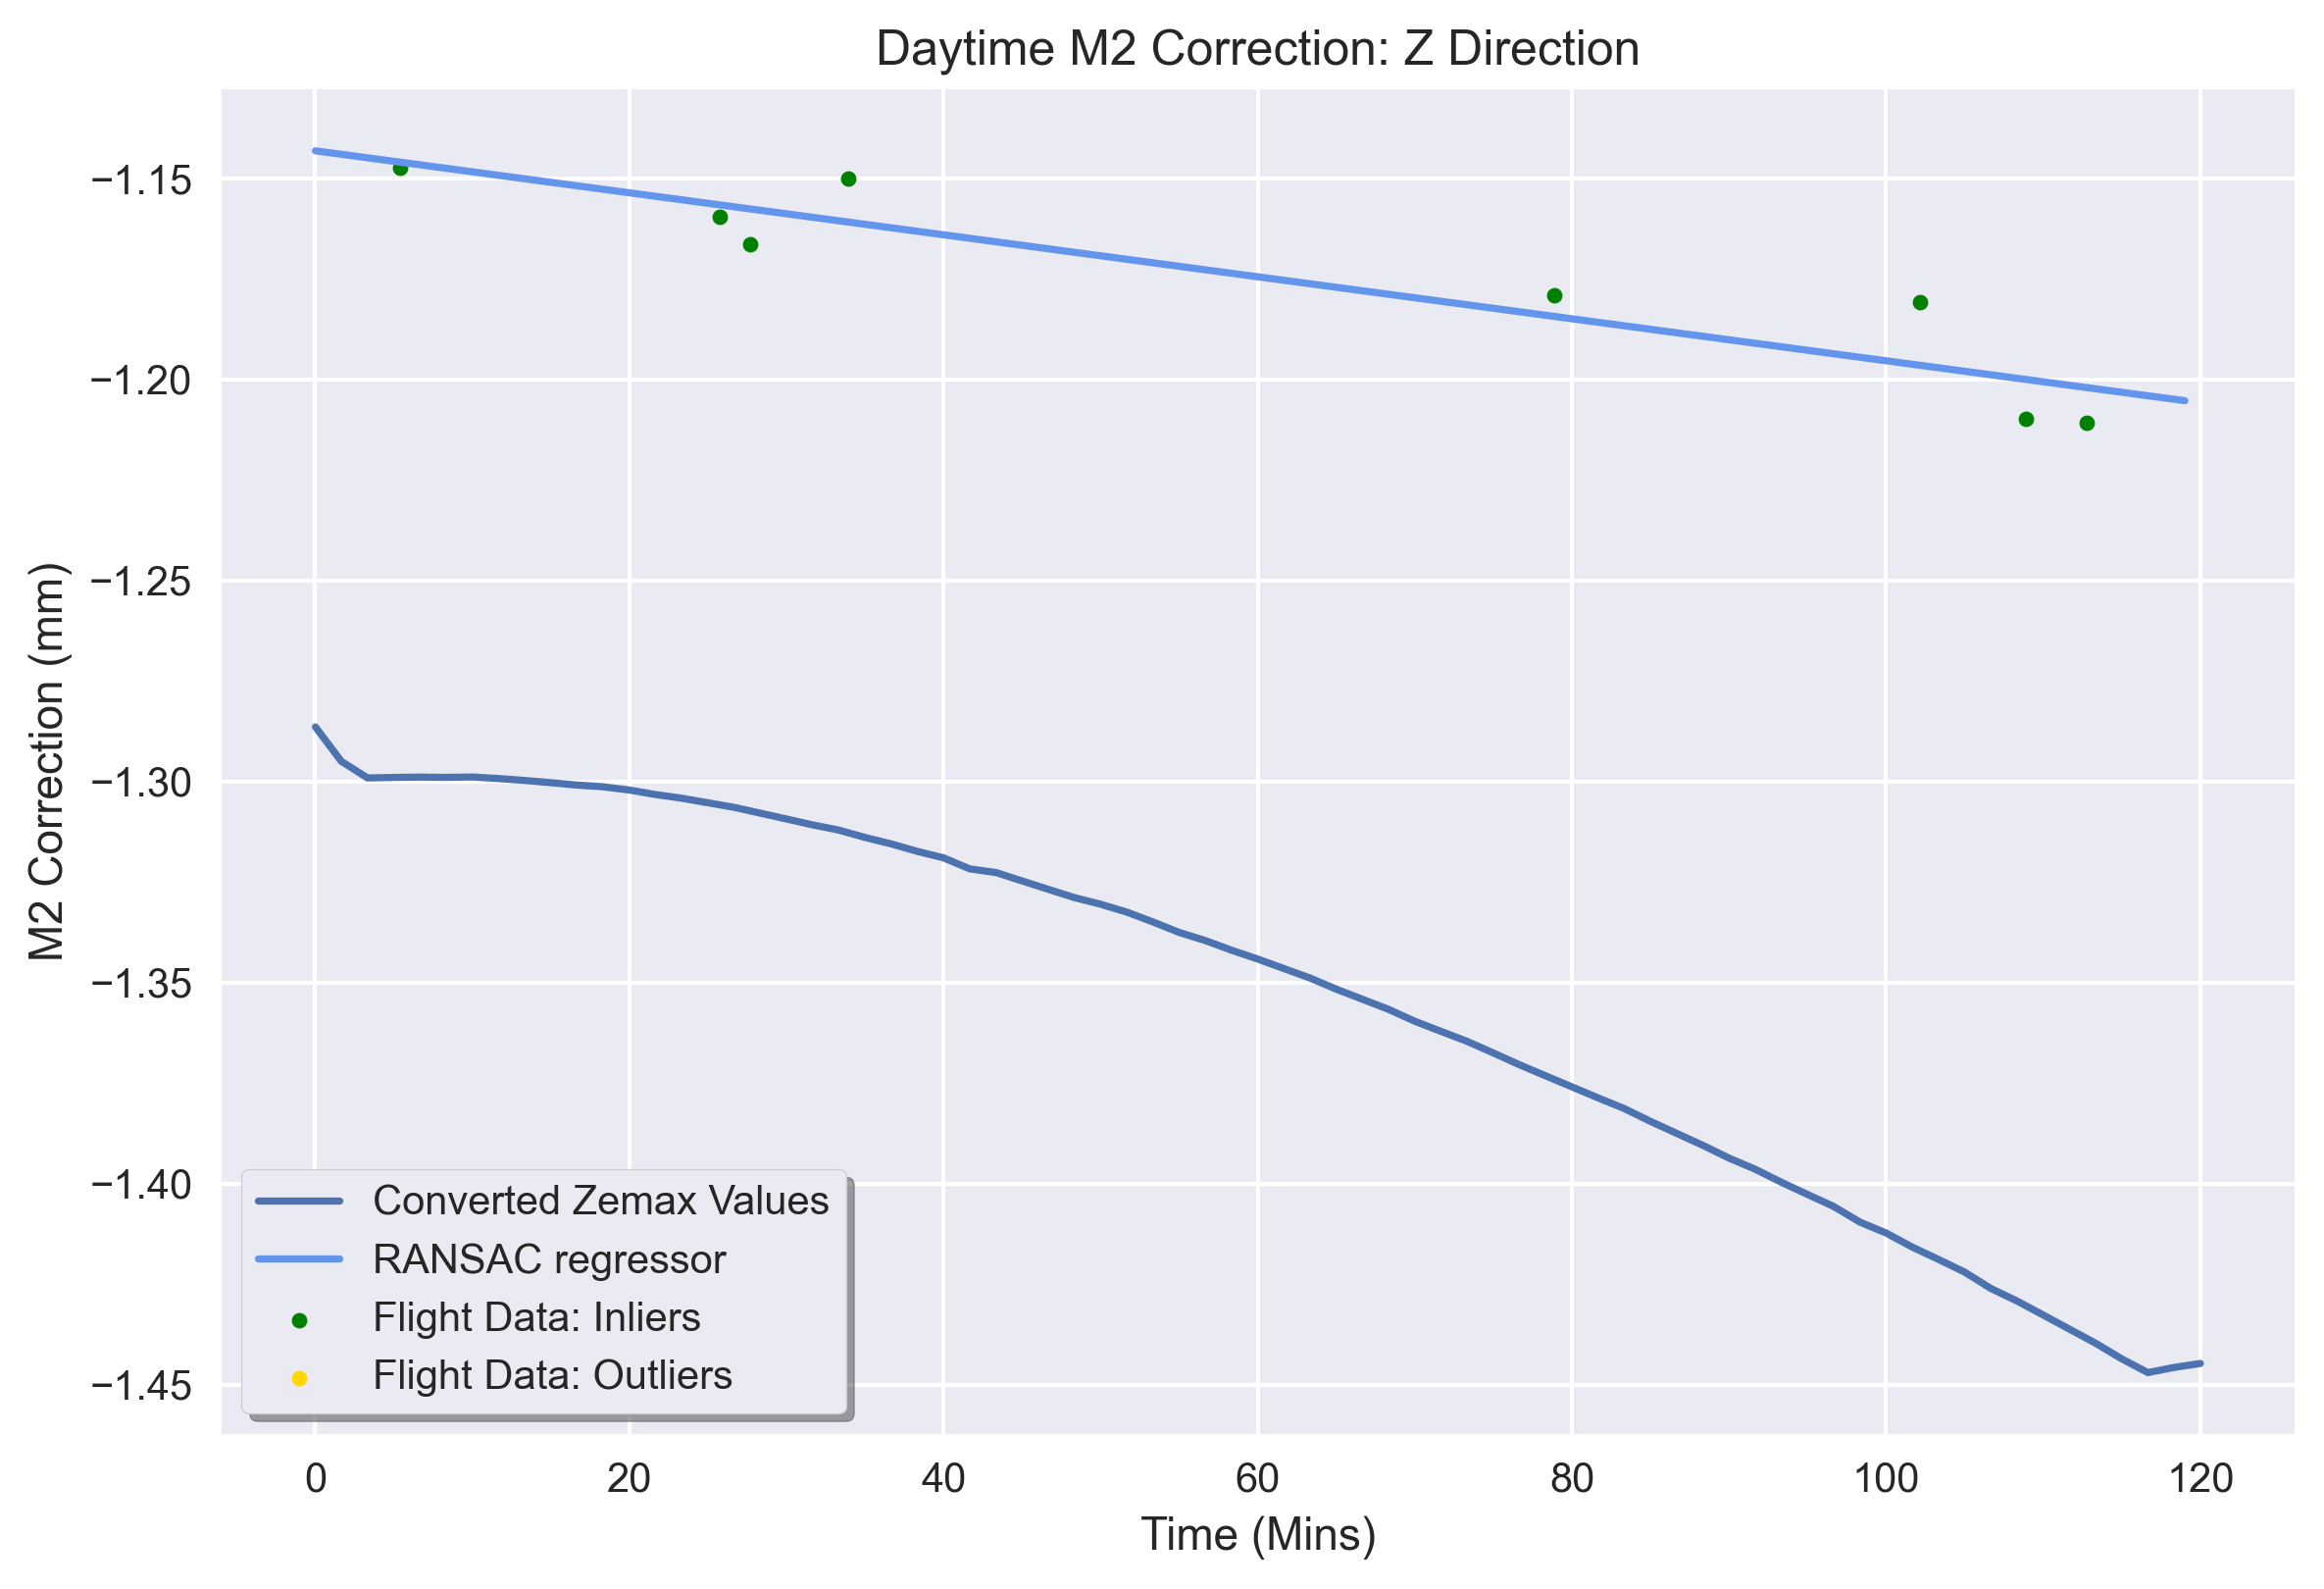

[-0.17372238]


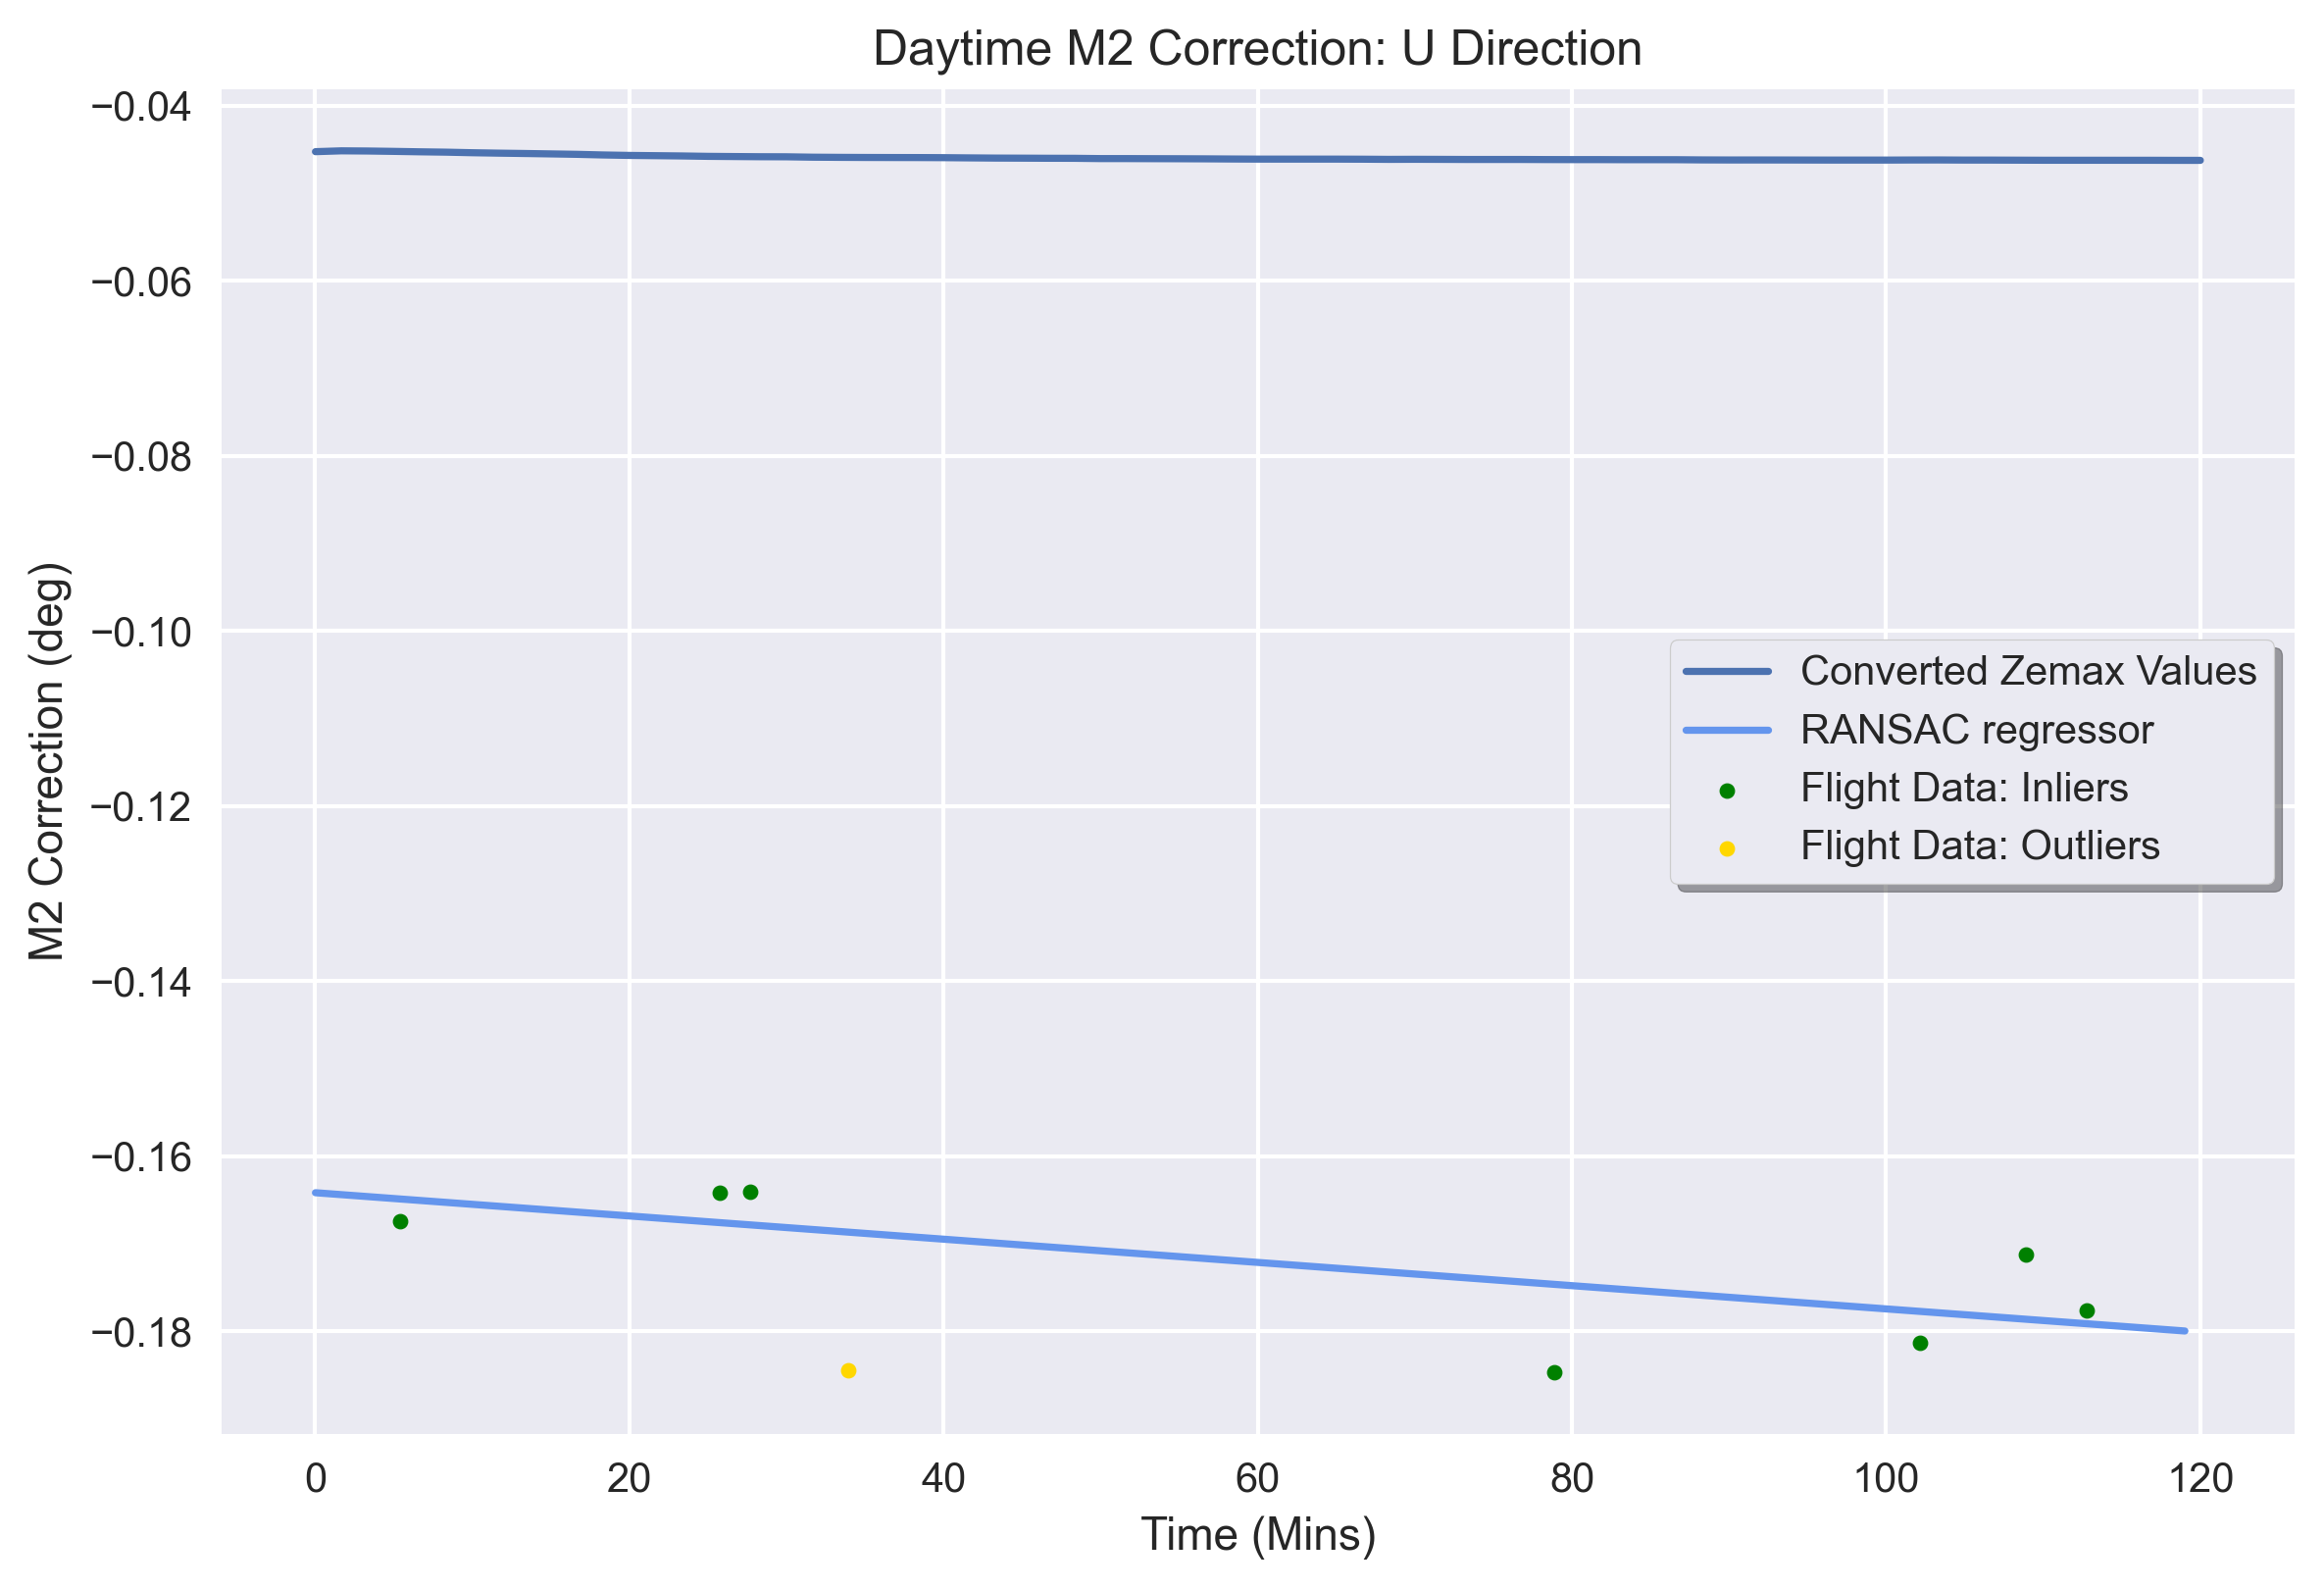

[-0.0656533]


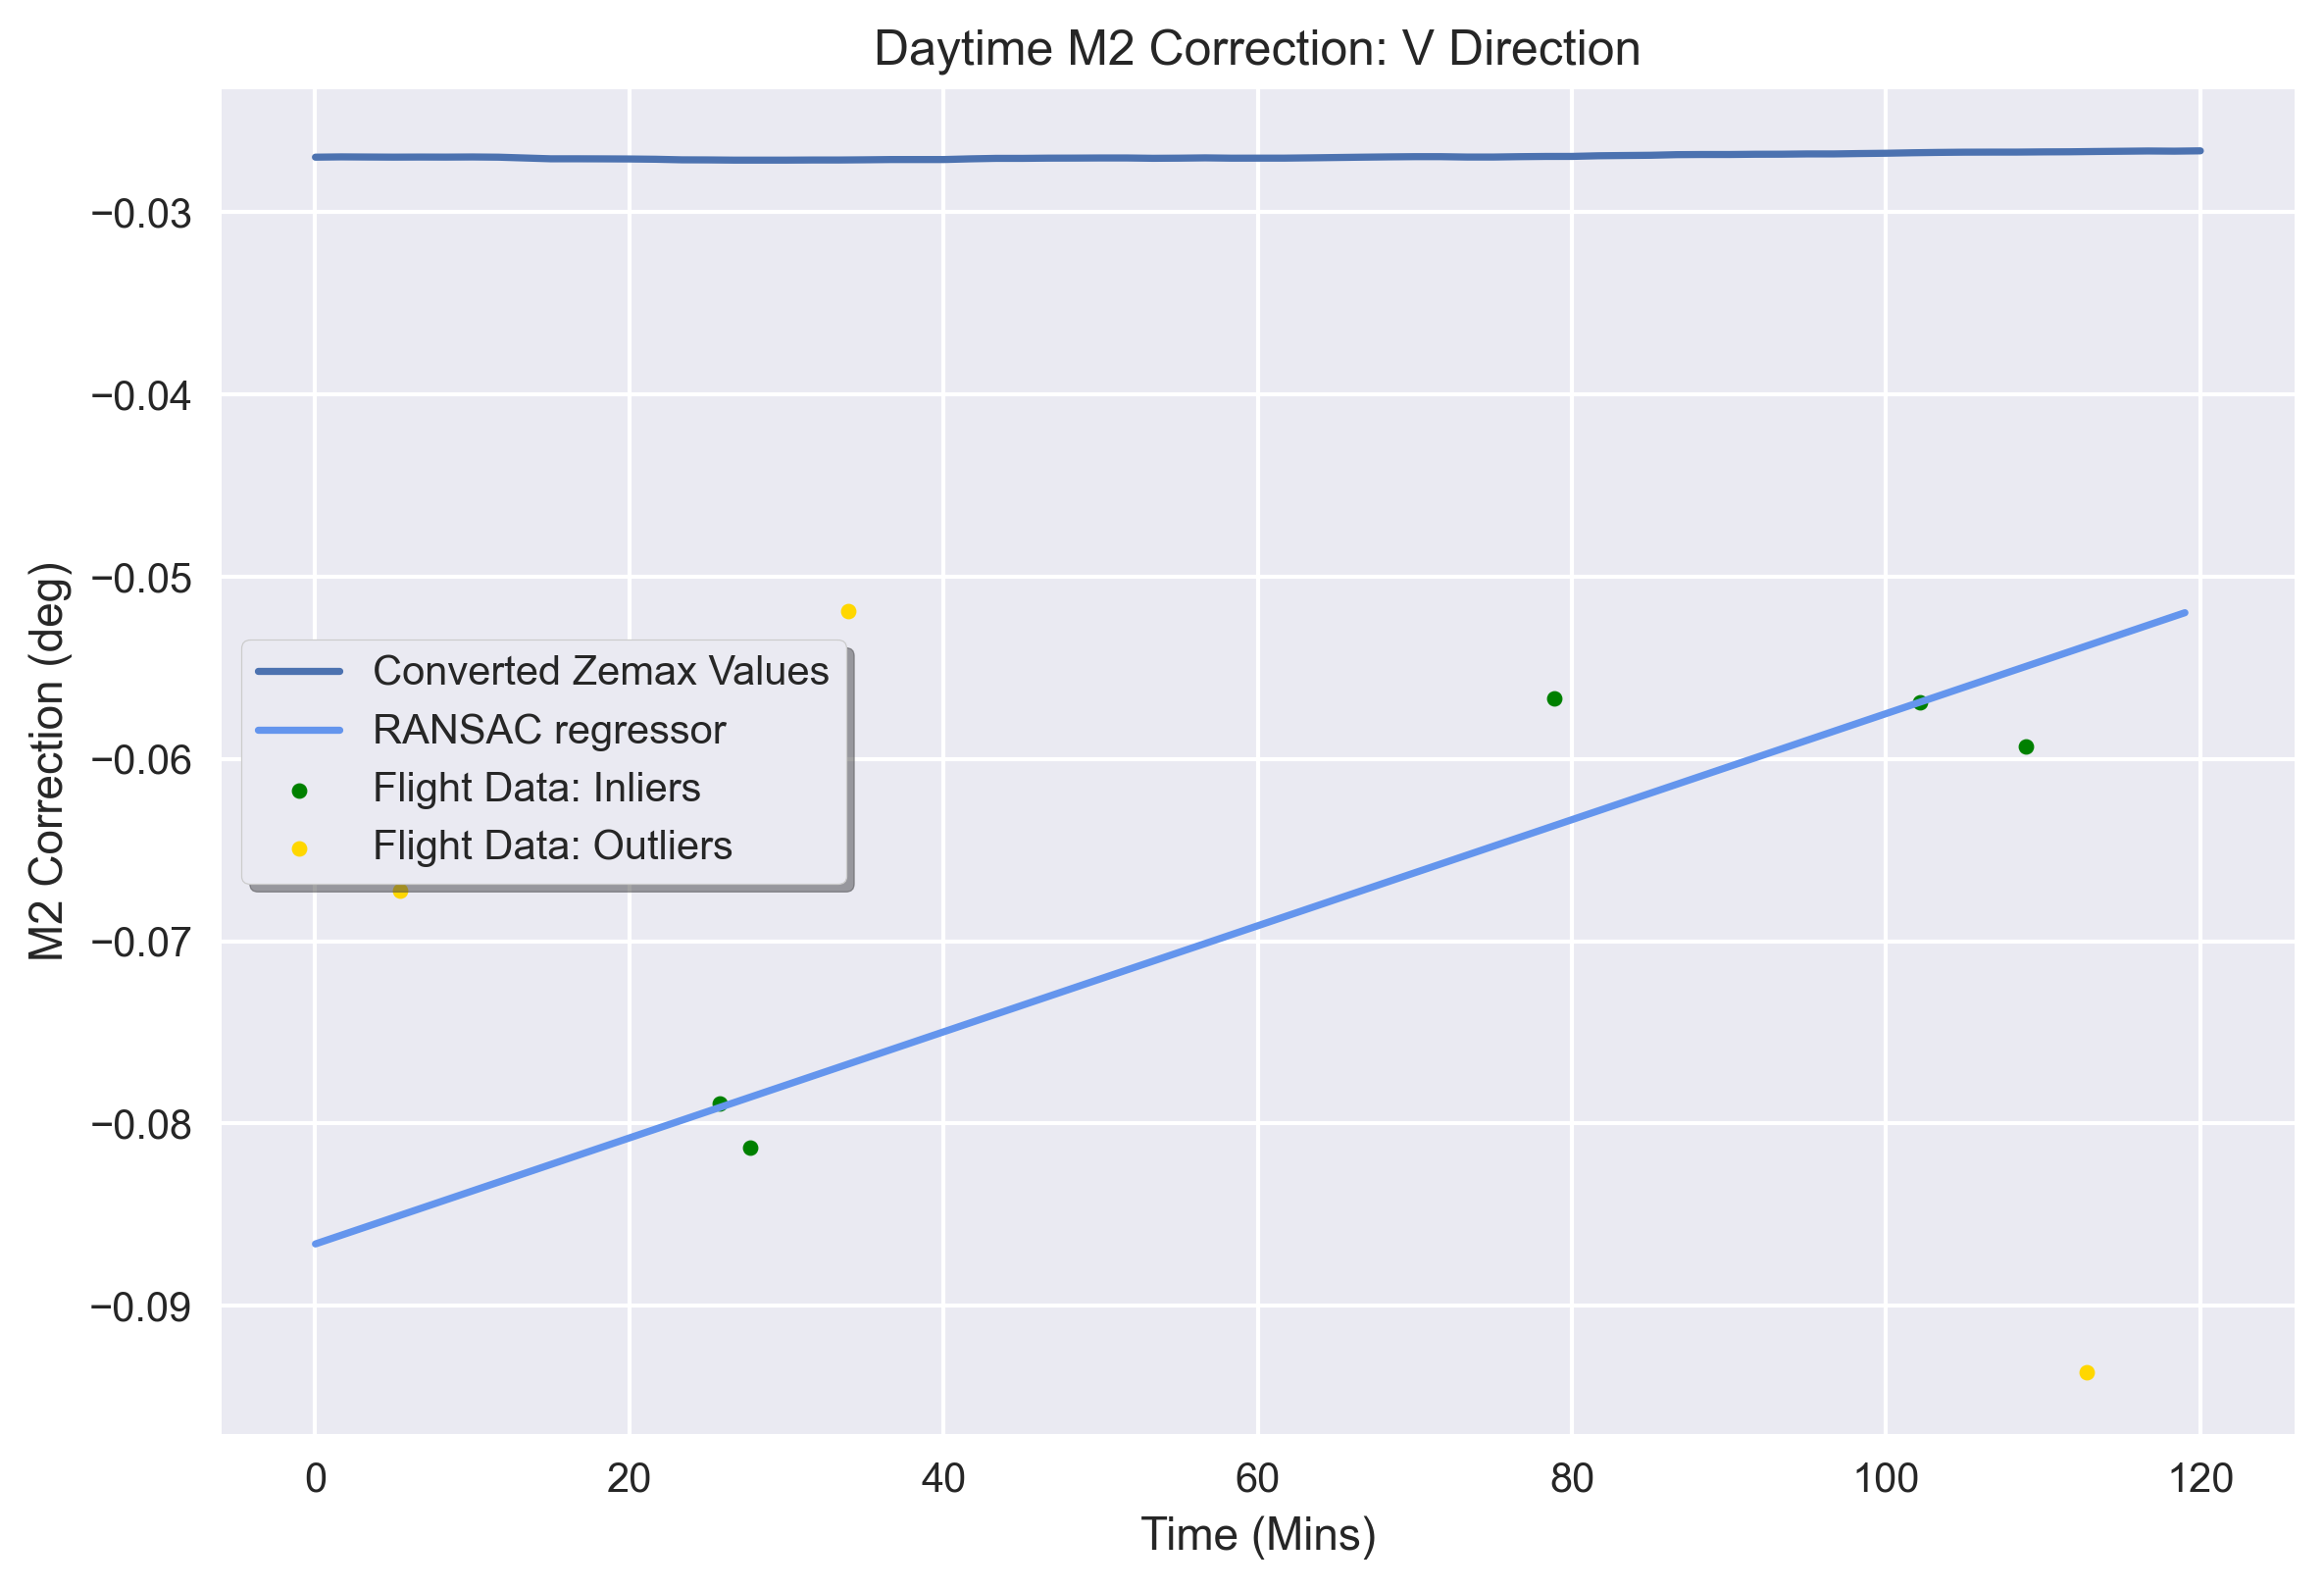

[-0.00052443]


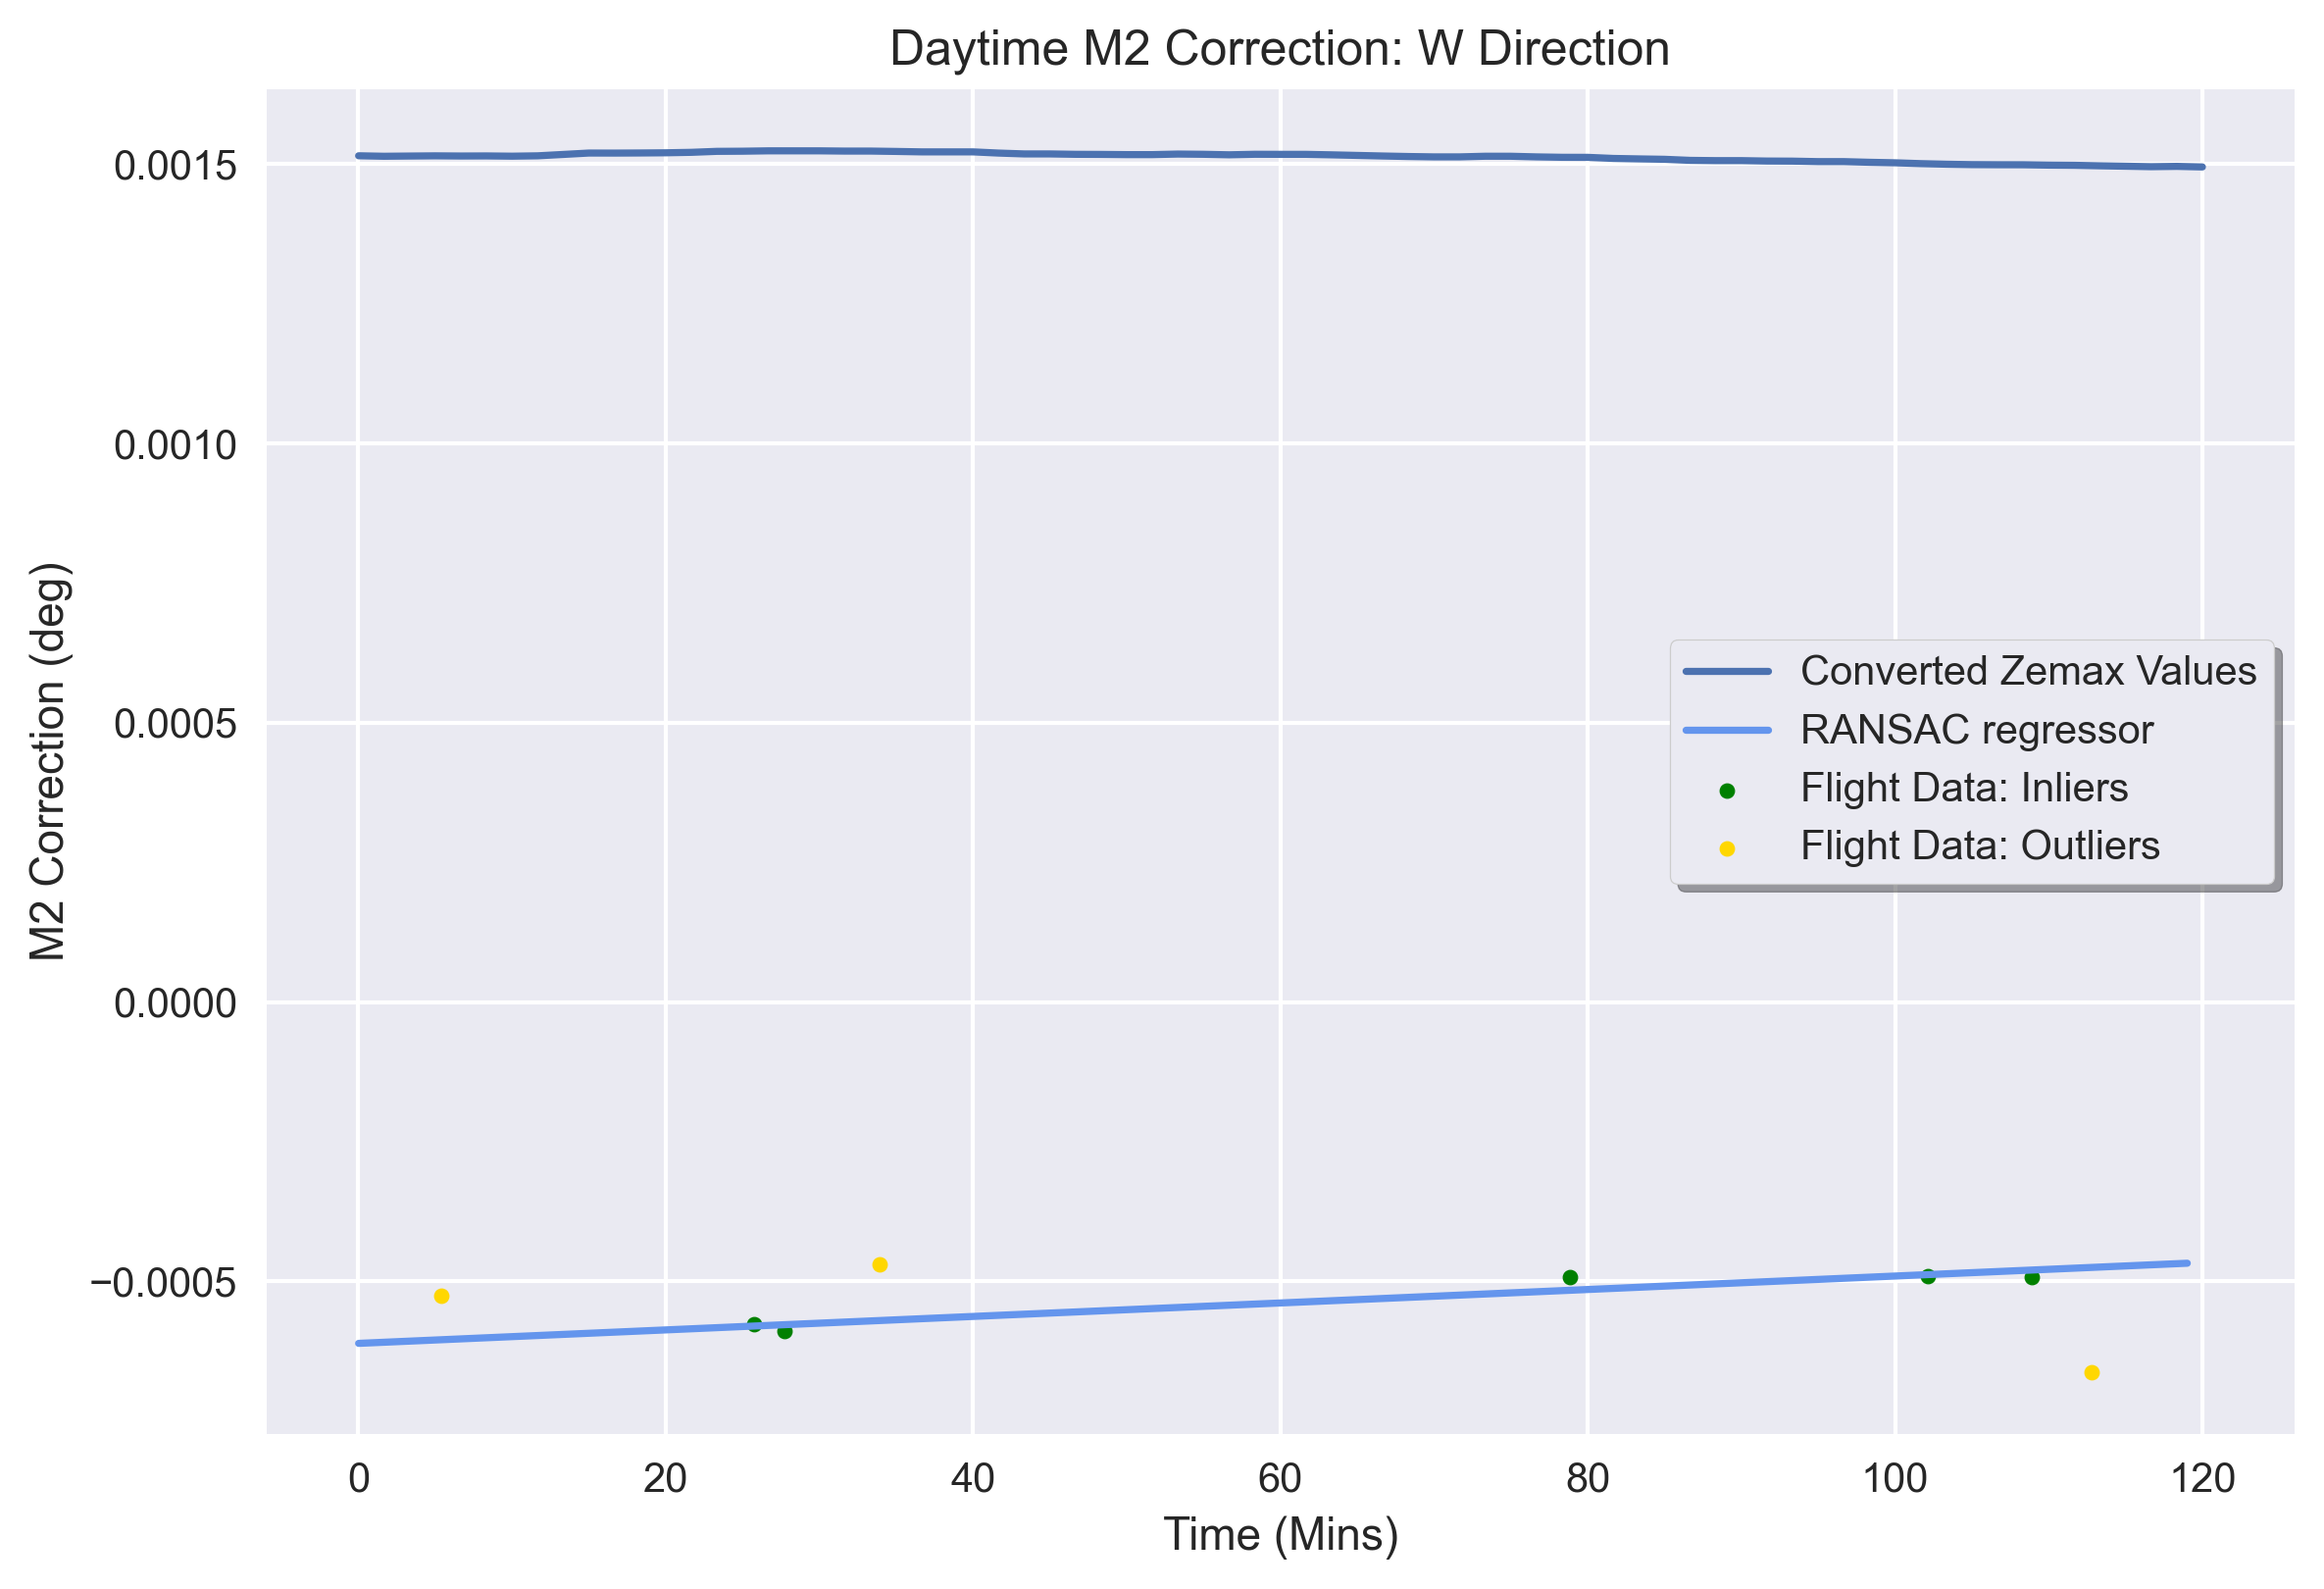

In [51]:
##Data Processing and Plotting Secondary correction
tmp = m2pos[:,0:nsteps]
sz = len(tmp[0,:])

#Convert Zemax Data
zemax_pos = np.zeros((6,sz))
for i in range(sz):
    zemax_pos[:,i] = convert_zmx(tmp[:,i])

#Convert flight data zemax basis
hex_data = scipyio.readsav('shkpkt_shk_m2align_full_hexapod.sav')
ftime = hex_data.hex_out_time
scope_pos = np.transpose(hex_data.hex_out_pos)

sz = len(scope_pos[0,:])
conv_pos = np.zeros((6,sz))
for i in range(sz):
    conv_pos[:,i] = convert_flight(scope_pos[:,i])

##Trim to time window
daysel = np.where(np.logical_and((13.75 <= ftime), (15.75 >= ftime)))
nightsel = np.where(np.logical_and((22.95 <= ftime), (24.95 >= ftime)))

ftime_day = (ftime[daysel]-13.75)*60
ftime_night = (ftime[nightsel]-22.95)*60
day_hex = conv_pos[:,daysel]
night_hex = conv_pos[:,nightsel]

print(zemax_pos[:,72])

#Make Time array
tarr = np.zeros(nsteps)
for i in range(nsteps):
    tmp = int(dir_list[i].split("_")[2])
    if (i>0):
        if tmp <= tarr[i-1]:
            tarr[i] = tarr[i-1]
        else:
            tarr[i] = tmp/60
    else:
        tarr[i] = tmp/60

axis = ['X', 'Y', 'Z', 'U', 'V', 'W']
for i in range(6):
    X = ftime_day.reshape(-1, 1)
    y = day_hex[i,:].reshape(-1,1)

    ransac = linear_model.RANSACRegressor(min_samples=0.5)
    ransac.fit(X,y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    line_X = np.arange(tarr.min(), tarr.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)

    plt.figure(dpi=300)
    plt.style.use('seaborn-v0_8')

    plt.plot(tarr,zemax_pos[i,:],label='Converted Zemax Values')
    plt.plot(line_X,line_y_ransac,color="cornflowerblue",label="RANSAC regressor")   
    plt.scatter(X[inlier_mask], y[inlier_mask], color="green", marker=".", label="Flight Data: Inliers")
    plt.scatter(X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Flight Data: Outliers")

    plt.title('Daytime M2 Correction: ' + axis[i] + ' Direction')
    plt.legend(frameon = True, shadow=True)
    plt.xlabel('Time (Mins)')

    if i >= 3:
        plt.ylabel('M2 Correction (deg)')
    else:
        plt.ylabel('M2 Correction (mm)')

    print(line_y_ransac[72])

    plt.tight_layout()

    #Save plot to file
    plt.savefig(plotdir+'M2corr_'+axis[i])
    plt.show()

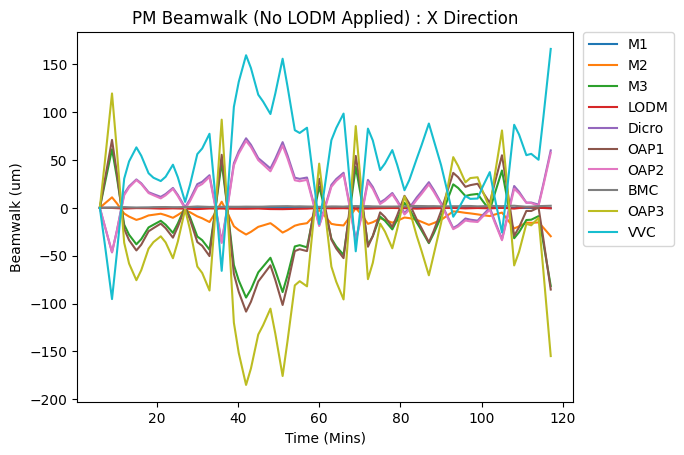

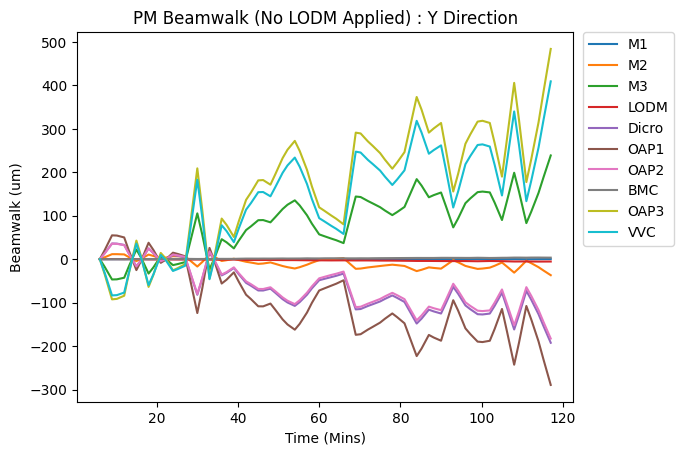

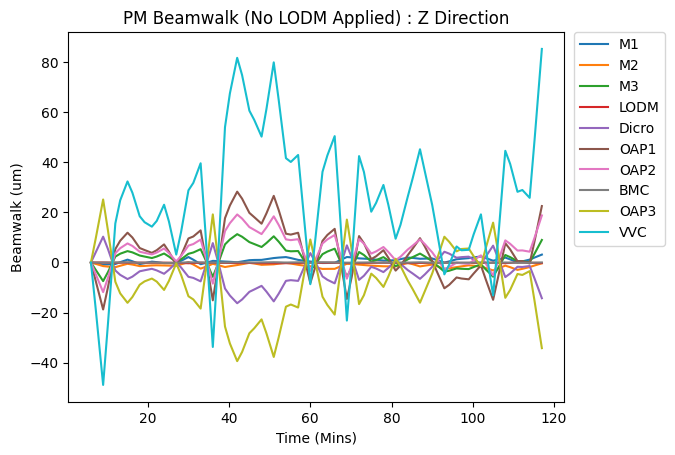

In [9]:
##Plot No LDOM Beamwalk
axis = ['X','Y','Z']

#Make Time array
tarr = np.zeros(nsteps)
for i in range(nsteps):
    tmp = int(dir_list[i].split("_")[2])
    if (i>0):
        if tmp <= tarr[i-1]:
            tarr[i] = tarr[i-1]
        else:
            tarr[i] = tmp/60
    else:
        tarr[i] = tmp/60

for j in range(3):
    plt.figure()
    plt.title(f'PM Beamwalk (No LODM Applied) : {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Beamwalk (um)')

    for i in range(n_surf):
        plt.plot(tarr[4:],2.54*10**4*(bwalk[i,j,4:]-bwalk[i,j,4]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.savefig(plotdir+'BW_noLODM_'+axis[j],bbox_inches='tight')
    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

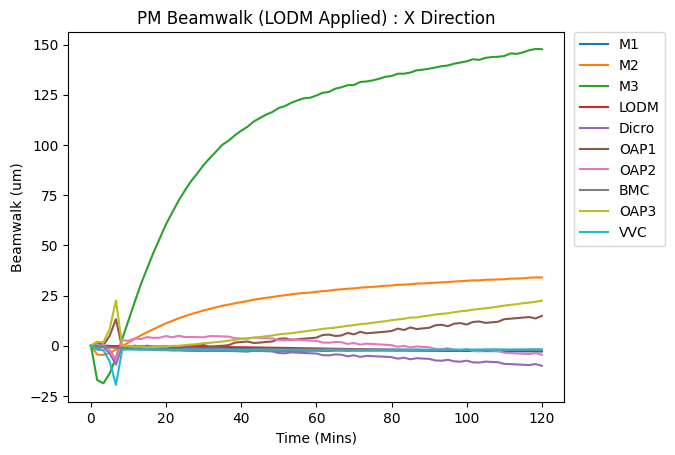

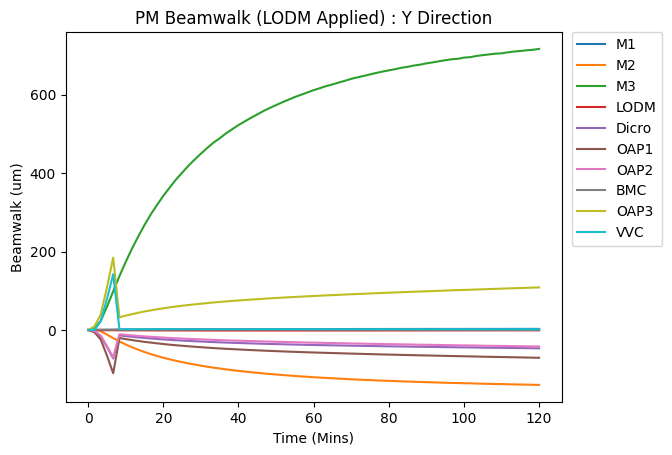

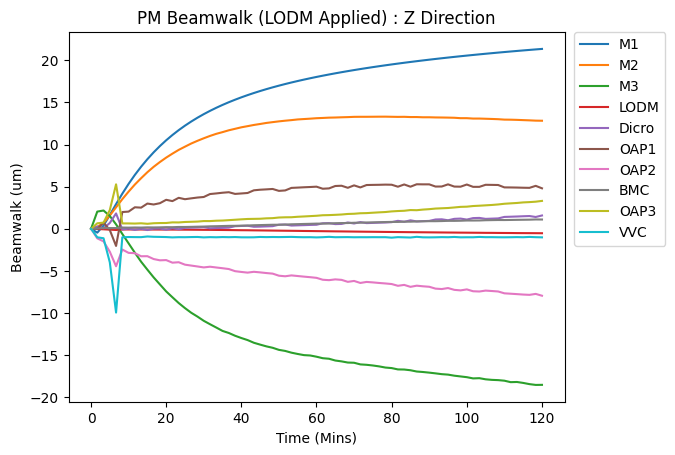

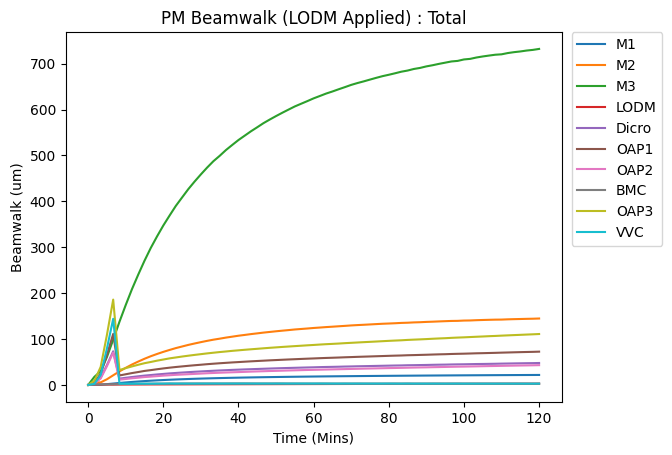

In [23]:
##Plot Beamwalk with LODM
axis = ['X','Y','Z']

#Make Time array
tarr = np.zeros(nsteps)
for i in range(nsteps):
    tmp = int(dir_list[i].split("_")[2])
    if (i>0):
        if tmp <= tarr[i-1]:
            tarr[i] = tarr[i-1]
        else:
            tarr[i] = tmp/60
    else:
        tarr[i] = tmp/60

for j in range(3):
    plt.figure()
    plt.title(f'PM Beamwalk (LODM Applied) : {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Beamwalk (um)')

    for i in range(n_surf):
        plt.plot(tarr[0:],2.54*10**4*(bwalk[i,j,0:]-bwalk[i,j,0]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.savefig(plotdir+'BW_yesLODM_'+axis[j],bbox_inches='tight')
    plt.show

plt.figure()
plt.title(f'PM Beamwalk (LODM Applied) : Total')
plt.xlabel('Time (Mins)')
plt.ylabel('Beamwalk (um)')

for i in range(n_surf):
    total = 25400 * np.sqrt((bwalk[i,0,0:]-bwalk[i,0,0])**2 + (bwalk[i,1,0:]-bwalk[i,1,0])**2 + (bwalk[i,2,0:]-bwalk[i,2,0])**2)
    plt.plot(tarr[0:],total)

plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig(plotdir+'BW_yesLODM_'+'total',bbox_inches='tight')
plt.show

In [14]:
##Save Wavefront and Beamwalk Data
outdir = 'C:\\Users\\locsst\\Desktop\\PICTURE_STOP_Rev2\\zemax\\data\\' + sub_dir
if not os.path.exists(outdir):
    os.makedirs(outdir)

#Beamwalk 
filename = 'beamwalk.csv'

#Create output array
big_arr = np.zeros((n_surf,2*nsteps+1))
big_arr[:,0] = [1,3,5,7,16,17,19,21,25,29]
for i in range(nsteps):
    big_arr[:,2*i+1] = 0.0254*bwalk[:,0,i]
    big_arr[:,2*i+2]   = 0.0254*bwalk[:,1,i]


with open(outdir+filename,'w',newline = '') as file:
    writen = csv.writer(file)
    writen.writerows(big_arr)

#Wavefront

#Calculate Sampling
r0 = 11.7064 #Primary Clear Radius
pixsize = r0/128 * 0.0254

#Create Header
header = fits.Header()
header['SCALE'] = str(pixsize)
header['UNITS'] = 'meters'

#Convert Data to Meters and write to file
for i in range(nsteps):
    filename = 'pm'+str(i+1) + '.fits'
    primary = fits.PrimaryHDU((6 *10**(-7))*wfcube[:,:,i],header=header)
    primary.writeto(outdir + filename, overwrite='True')